# Прогнозирование оттока клиентов

## Введение

**Цель проекта**

Разработать решение для оператора связи, позволяющее управлять рисками оттока клиентов.

**Задача проекта**
1. Разработка нескольких моделей для предсказания расторжения контракта.
2. Выбор лучшей модели.
3. Анализ признаков, указывающих на повышенный риск разрыва контракта.

**Критерии качества моделей:**
- Качество предсказания: значение метрики ROC_AUC > 0.85.
____

**О данных**

**Датасет phone** содержит информацию об услугах телефонии.
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

**Датасет internet** содержит информацию о интернет-услугах.
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

**Датасет personal** содержит персональные данные клиента.
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

**Датасет contract** содежит информацию о договоре.
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

_____

**План проекта**

Для разработки каждой модели будут реализованы следующие шаги.
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Корреляционный анализ
4. Обучение и выбор моделей
5. Анализ важности признаков

Далее будет описан общий вывод.

## Импорт библиотек

In [1]:
#установка библиотек
import sys
!{sys.executable} -m pip install phik -q

!pip install catboost -q
!pip install -U scikit-learn -q
!pip install shap -q

In [2]:
#импорт библиотек
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from phik import phik_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.metrics import (roc_auc_score, 
    accuracy_score,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_curve)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier

import shap

RANDOM_STATE = 80925

## Функции для работы

In [3]:
#функция для обзора данных
def data_overview(data):
    display(data.head(10))
    print('')
    display(data.sample(10))
    print('')
    display(data.info())
    print('')
    display(data.describe(include='all').T)
    print('')
    print('')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('')
    print('Кол-во пропусков:')
    display(data.isna().sum())
    print('')

In [4]:
#функция для обработки названий столбцов
def camel_to_snake(col):
    col = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    col = re.sub('([a-z0-9])([A-Z])', r'\1_\2', col)
    return col.lower()

In [5]:
#функция для визуализации распределения категориальных признаков в контексте целевого
def countplot_plot_for_cats(column, title, y_label, x_label):
    plt.figure(figsize=(10, 6))
    
    total = len(data)
    order = data[column].value_counts().index

    ax = sns.countplot(
        x=column,
        data=data,
        hue='breakup_status',
        palette=['#87CEEB', '#A12343'],
        order=order)

    for p in ax.patches:
        height = p.get_height()
        if height == 0:
            continue  # пропускаем пустые бары
        percent = f'{100 * height / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = height
        ax.annotate(percent, (x, y), ha='center', va='bottom', fontsize=9, color='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='breakup_status')
    plt.tight_layout()
    plt.show()


In [6]:
#функция для визуализации распределения целевого признака
def cutie_pie_chart(column, the_title):
    palette = ['#87CEEB', '#A12343']

    
    data[column].value_counts().plot(
    kind='pie',
    title=the_title,
    autopct='%.0f%%',
    ylabel='',
    colors=palette)

    plt.show()

In [7]:
#функция для обзора неприрывных количественных признаков
def hist_and_box_chart(column, title, x_label, bins):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"{title}", fontsize=16)
    palette = ['#87CEEB', '#4682B4', '#1E90FF', 
               '#00BFFF', '#00CED1', '#40E0D0', 
               '#468499', '#B0E0E6', '#66CDAA', '#6495ED']
    
    #гистограмма
    data[column].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[0],
        color=palette[:len(column)],
        bins=bins
    )
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('Количество клиентов')
    axes[0].set_title("Гистограмма")

    median = data[column].median()
    mean = data[column].mean()
    axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[0].legend()


    #боксплот
    data[column].plot(
        kind='box',
        ax=axes[1],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'}
    )
    axes[1].set_xlabel(x_label)
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()


In [8]:
#функция для сравнительного обзора количественных признаков
def hist_for_two(suptitle, feature, set_xlabel):
    data_active = data.query('breakup_status == 0')
    data_non_active = data.query('breakup_status == 1')
    
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2]) 
    
    axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3]),]
    fig.suptitle(suptitle, fontsize=16)
    
    palette = ['#87CEEB', '#4682B4', '#1E90FF', '#00BFFF', '#00CED1', '#40E0D0', '#468499', '#B0E0E6', '#66CDAA', '#6495ED']
    
    #гистограммы
    data_active[feature].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[0],
        color=palette[0],
        bins=20)
    
    axes[0].set_ylabel('Количество клиентов')
    axes[0].set_title("Активные контракты")
    axes[0].set_xticklabels([])
    
    median = data_active[feature].median()
    mean = data_active[feature].mean()
    axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[0].legend()
    
    data_non_active[feature].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[2],
        color=palette[0],
        bins=20)
    axes[2].set_ylabel('Количество клиентов')
    axes[2].set_title("Прекращенные контракты")
    axes[2].set_xlabel(set_xlabel)
    
    median = data_non_active[feature].median()
    mean = data_non_active[feature].mean()
    axes[2].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[2].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[2].legend()
    
    #боксплоты
    data_active[feature].plot(
        kind='box',
        ax=axes[1],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'})
    
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_title('Активные контракты')
    axes[1].set_xticklabels([])
    
    data_non_active[feature].plot(
        kind='box',
        ax=axes[3],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'})
    
    axes[3].set_xlabel(set_xlabel)
    axes[3].set_yticklabels([])
    axes[3].set_ylabel('')
    axes[3].set_title("Прекращенные контракты")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Предобработка данных 

### Импорт и обзор данных

In [9]:
#импортируем данные
try:
    phone = pd.read_csv('Desktop/practicum cases/final/phone_new.csv')
except:
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

try:
    internet = pd.read_csv('Desktop/practicum cases/final/internet_new.csv')
except:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

try:
    personal = pd.read_csv('Desktop/practicum cases/final/personal_new.csv')
except:
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

try:
    contract = pd.read_csv('Desktop/practicum cases/final/contract_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

In [10]:
data_overview(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


,customerID,MultipleLines
4183,3932-IJWDZ,Yes
5,7892-POOKP,Yes
2810,2386-LAHRK,No
3372,2103-ZRXFN,Yes
4495,2612-RRIDN,No
5844,2669-QVCRG,Yes
2101,4706-DGAHW,No
4707,6907-FLBER,Yes
5381,6080-LNESI,Yes
2333,1849-RJYIG,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,count,unique,top,freq
customerID,6361,6361,3186-AJIEK,1
MultipleLines,6361,2,No,3390




Кол-во явных дубликатов: 0

Кол-во пропусков:


customerID       0
MultipleLines    0
dtype: int64

In [11]:
data_overview(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3807,7869-ZYDST,DSL,No,No,No,No,Yes,No
588,7595-EHCDL,DSL,No,No,Yes,No,Yes,Yes
2013,3230-JCNZS,Fiber optic,Yes,Yes,Yes,No,Yes,No
3718,1043-UXOVO,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
2059,5315-CKEQK,DSL,No,No,No,No,No,No
1384,7801-CEDNV,DSL,Yes,No,No,No,No,No
4304,2676-OXPPQ,DSL,Yes,Yes,No,No,No,No
1154,0222-CNVPT,DSL,Yes,No,No,No,Yes,Yes
1060,6475-VHUIZ,DSL,No,No,Yes,Yes,No,No
1000,7595-EUIVN,Fiber optic,No,Yes,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,count,unique,top,freq
customerID,5517,5517,3186-AJIEK,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785




Кол-во явных дубликатов: 0

Кол-во пропусков:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [12]:
data_overview(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents
3548,0670-ANMUU,Male,0,No,No
6827,1036-GUDCL,Male,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
4740,2778-OCLGR,Male,1,Yes,No
2941,6176-YJWAS,Male,0,Yes,No
5911,1976-AZZPJ,Male,0,Yes,No
6462,8413-VONUO,Male,0,No,No
4209,4385-ZKVNW,Male,0,Yes,Yes
539,5394-MEITZ,Female,0,Yes,Yes
6149,3069-SSVSN,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Кол-во явных дубликатов: 0

Кол-во пропусков:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [13]:
data_overview(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1417,5651-WYIPH,2018-08-01,No,Month-to-month,Yes,Credit card (automatic),49.85,960.11
1571,2812-SFXMJ,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05
3193,1407-DIGZV,2019-11-01,No,Two year,No,Mailed check,19.10,59.59
672,3276-HDUEG,2019-09-01,No,Month-to-month,Yes,Mailed check,75.05,409.02
5037,8943-URTMR,2019-09-01,No,Month-to-month,Yes,Mailed check,79.65,398.25
2848,7508-KBIMB,2018-02-01,No,One year,Yes,Credit card (automatic),56.25,1471.5
2377,9308-ANMVE,2016-03-01,No,Month-to-month,Yes,Electronic check,55.30,2599.1
4985,4827-DPADN,2014-02-01,2017-12-01,Two year,Yes,Bank transfer (automatic),83.30,3831.8
3815,9306-CPCBC,2019-09-01,No,Month-to-month,Yes,Electronic check,74.25,371.25
1169,1282-IHQAC,2014-04-01,No,One year,Yes,Credit card (automatic),44.05,3083.5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Кол-во явных дубликатов: 0

Кол-во пропусков:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

**Итог обзора данных**

**phone**: информация об услугах телефонии.
- Названия столбцов требуют корректировки.
- Всего строк 6361.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных верный.
- Пропущенных значений нет.
_______

**internet**: информация об интернет-услугах.
- Названия столбцов требуют корректировки.
- Всего строк 5517.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных верный.
- Пропущенных значений нет.
_______

**personal**: персональные данные клиента.
- Названия столбцов требуют корректировки.
- Всего строк 7043.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных верный, однако тип и содержимое в столбце SeniorCitizen для единообразия и отсутствия путаницы мы приведем к общему формату всех датасетов - 'Yes/No', строчный тип.
- Пропущенных значений нет.
_______

**contract**: информация о договоре.
- Названия столбцов требуют корректировки.
- Всего строк 7043.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных TotalCharges требует коррекции на float64.
- Тип данных BeginDate и EndDate формально тоже стоит сменить на datetime, но это мы сделаем после выделении целевого признака - "статус договора", - и чтобы создать признак длительности договора. Исходные признаки удалим, чтобы модель не привязывалась к определенному периоду.
- Пропущенных значений нет.
________

**Объединение данных после предобработки**
- Объединение сделаем по ID потребителей.
- Сейчас в столбцах с базовой иноформацией о клиентах - их контракт и личные данные, - одинаковое число строк, и скорее всего ID там совпадут.
- В случае отсутствия пользователя в числе потребителей телефонии или интернета, мы заполним соответствующие признаки для таких пользователей заглушкой NA.

### Предобработка phone

In [14]:
#приведем названия столбцов к нижнему регистру
phone.columns = [camel_to_snake(col) for col in phone.columns]
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Предобработка internet

In [15]:
#приведем названия столбцов к нижнему регистру
internet.columns = [camel_to_snake(col) for col in internet.columns]
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


### Предобработка personal

In [16]:
#приведем названия столбцов к нижнему регистру
personal.columns = [camel_to_snake(col) for col in personal.columns]
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [17]:
#приведем содержимое senior_citizen к общему формату схожих категориальных признаков в датасете: Yes/No и тип object
personal['senior_citizen'] = personal['senior_citizen'].replace({0: 'No', 1: 'Yes'}).astype(str)

#проверим успехи
display(personal.head())
print('')
display(personal.info())
print('')
display(personal['senior_citizen'].value_counts())

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64

### Предобработка contract

In [18]:
#приведем названия столбцов к нижнему регистру
contract.columns = [camel_to_snake(col) for col in contract.columns]
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [19]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract['total_charges'] = contract['total_charges'].astype('float')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [20]:
#посмотрим на нож в спине
contract.loc[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


- Выявленные пропуски в общих расходах абонента - это абоненты, которые, заключили договор буквально в день выгрузки данных.
- Здравый смысл говорит, что такие абоненты уже должны были совершить первичный платеж (полный/месячный/какой-нибудь). Однако, зачем здравый смысл, когда можно проверить, как графа общих расходов ведется конкретно в этих данных.

In [21]:
#проверим бухгалтерию клинентов, которые имеют тот же тип контрактов, но заключили их на месяц раньше
contract.query('begin_date == "2020-01-01" & (type == "Two year" | type == "One year")')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
222,6469-MRVET,2020-01-01,No,One year,Yes,Electronic check,20.20,20.20
1168,5562-BETPV,2020-01-01,No,One year,No,Mailed check,19.65,19.65
1286,8985-OOPOS,2020-01-01,No,One year,No,Credit card (automatic),74.10,74.84
1654,2967-MXRAV,2020-01-01,No,One year,No,Mailed check,18.80,19.74
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45
2993,2239-CFOUJ,2020-01-01,No,One year,No,Mailed check,20.40,21.62
4767,1064-FBXNK,2020-01-01,No,One year,No,Credit card (automatic),19.85,21.44
5987,1099-GODLO,2020-01-01,No,Two year,No,Mailed check,20.35,20.76
6149,3069-SSVSN,2020-01-01,No,One year,No,Mailed check,25.85,26.37


- Общие расходы в любом случае считаются по факту: т.е. за *прошедший* месяц начисляется сумма, равная месячному платежу.
- В случае пропусков с контрактами, заключенными в день выгрузки, мы должны заполнить графу total_charges нулями.

In [22]:
#заполним пропуски нулями
contract.loc[contract['total_charges'].isna(), 'total_charges'] = 0

#оценим свои успехи
contract.query('begin_date == "2020-02-01"')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


In [23]:
#создадим целевой признак - статус контракта, - исходя из значения признака end_date
#по умолчанию всем присвоим 1, а если контракт активен - 'No' в end_date, - то он будет 0
contract['breakup_status'] = 1
contract.loc[contract['end_date'] == 'No', 'breakup_status'] = 0

#проверимся на успешность
contract.sample(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status
1277,4821-WQOYN,2014-02-01,2017-06-01,Two year,Yes,Credit card (automatic),20.10,804.00,1
3849,5089-IFSDP,2015-01-01,2018-03-01,Two year,Yes,Bank transfer (automatic),109.45,4159.10,1
550,3580-HYCSP,2014-02-01,No,Two year,Yes,Bank transfer (automatic),110.30,7941.60,0
1773,2007-QVGAW,2014-06-01,2018-12-01,Two year,Yes,Bank transfer (automatic),19.35,1044.90,1
2994,8046-DNVTL,2014-12-01,2017-07-01,Two year,Yes,Credit card (automatic),38.60,1292.33,1
4262,5485-WUYWF,2019-11-01,No,Month-to-month,No,Bank transfer (automatic),66.40,199.20,0
924,4824-GUCBY,2018-04-01,No,Month-to-month,No,Electronic check,81.70,1923.22,0
3592,6128-CZOMY,2019-11-01,No,Month-to-month,Yes,Electronic check,45.65,146.54,0
5005,2359-QWQUL,2016-10-01,2019-12-01,One year,Yes,Credit card (automatic),104.70,4376.46,1
6643,3411-WLRSQ,2019-11-01,No,Month-to-month,Yes,Bank transfer (automatic),74.60,223.80,0


In [24]:
#выделим длительность контракта в отдельный признак, отняв из даты окончания контракта дату его начала
#для активных контрактов даты окончания нет, поэтому их длительность мы будем оценивать в сравнении с датой выгрузки данных - и поэтому заменим "No" в end_date на дату выгрузки, т.е. 2020-02-01
contract.loc[contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

#проверимся на успешность
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


In [25]:
#изменим формат данных 
contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors='coerce')
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')

#проверимся на успешность и внезапные пропуски
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   breakup_status     7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [26]:
#вычислим длительность 
contract['duration_days'] = (contract['end_date'] - contract['begin_date']).dt.days

#проверимся на успешность
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


- Как удобно, что в первой строке контракту всего месяц, и можно даже проверить цифры за машиной.

In [27]:
#удалим признаки начала и окончания контракта, т.к. модель в любом случае не должна искать логику в конкретных датах
contract = contract.drop(['begin_date', 'end_date'], axis=1)

#проверимся на успешность
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status,duration_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


### Объединение данных

In [28]:
#сначала объединим по id таблицы с совпадающим числом строк и посмотрим, насколько верна была мысль про то, что id совпадут полностью
contract_and_personal = pd.merge(contract, personal, on='customer_id', how='inner')
contract_and_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   breakup_status     7043 non-null   int64  
 7   duration_days      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 660.4+ KB


In [29]:
#добавим данные по телефонии
contract_and_personal_and_phone = contract_and_personal.merge(phone, on='customer_id', how='left')
contract_and_personal_and_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   breakup_status     7043 non-null   int64  
 7   duration_days      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 715.4+ KB


In [30]:
#добавим данные по интернету
data = contract_and_personal_and_phone.merge(internet, on='customer_id', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   breakup_status     7043 non-null   int64  
 7   duration_days      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [31]:
#заполним пробелы в знаниях по части телефонии и интернета значением-маской Unknown
data = data.fillna('NA')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   breakup_status     7043 non-null   int64  
 7   duration_days      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

In [32]:
data_overview(data)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status,duration_days,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,NA,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,NA,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,No,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,No,No,No,NA,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,No,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,One year,No,Bank transfer (automatic),56.15,1628.35,1,882,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No


,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status,duration_days,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
6153,6685-XSHHU,Two year,Yes,Bank transfer (automatic),20.95,1382.70,0,1826,Male,No,Yes,Yes,No,NA,NA,NA,NA,NA,NA,NA
5664,0875-CABNR,Month-to-month,Yes,Credit card (automatic),84.60,1132.79,0,396,Female,Yes,No,No,No,Fiber optic,No,No,Yes,No,No,Yes
3511,3785-KTYSH,Two year,No,Mailed check,24.60,172.20,1,213,Male,No,No,No,Yes,NA,NA,NA,NA,NA,NA,NA
5743,2384-OVPSA,Two year,No,Mailed check,20.20,767.60,0,1157,Female,Yes,No,No,No,NA,NA,NA,NA,NA,NA,NA
33,7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,No,No,No,No,NA,NA,NA,NA,NA,NA,NA
2496,2333-KWEWW,Two year,No,Credit card (automatic),20.05,396.99,0,549,Male,No,No,No,No,NA,NA,NA,NA,NA,NA,NA
3045,9114-AAFQH,One year,Yes,Electronic check,65.65,3151.20,0,1461,Female,No,Yes,No,No,DSL,No,Yes,Yes,No,No,Yes
6912,2215-ZAFGX,Month-to-month,Yes,Electronic check,85.50,838.76,0,276,Male,No,No,No,Yes,Fiber optic,No,No,No,No,Yes,No
6778,5893-KCLGT,Two year,Yes,Mailed check,19.75,325.88,1,454,Female,No,No,Yes,No,NA,NA,NA,NA,NA,NA,NA
1510,7898-PDWQE,Two year,No,Credit card (automatic),80.40,5708.40,0,2163,Male,No,Yes,No,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   breakup_status     7043 non-null   int64  
 7   duration_days      7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7043.0,NaN,NaN,NaN,2115.312885,2112.742814,0.0,436.75,1343.35,3236.69,9221.38
breakup_status,7043.0,NaN,NaN,NaN,0.156325,0.363189,0.0,0.0,0.0,0.0,1.0
duration_days,7043.0,NaN,NaN,NaN,898.555729,683.13051,0.0,276.0,761.0,1461.0,2314.0
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043,2,No,5901,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Кол-во явных дубликатов: 0

Кол-во пропусков:


customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
breakup_status       0
duration_days        0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

### Выводы по предобработке данных

**phone**: информация об услугах телефонии.
- Названия приведены к нижнему регистру.
- Всего строк 6361.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных верный.
- Пропущенных значений нет.
_______

**internet**: информация об интернет-услугах.
- Названия столбцов приведены к нижнему регистру.
- Всего строк 5517.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных верный.
- Пропущенных значений нет.
_______

**personal**: персональные данные клиента.
- Названия столбцов приведены к нижнему регистру.
- Всего строк 7043.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных данных в senior_citizen для единообразия и отсутствия путаницы приведены к общему формату всех датасетов - 'Yes/No', строчный тип.
- Пропущенных значений нет.
_______

**contract**: информация о договоре.
- Названия столбцов приведены к нижнему регистру.
- Всего строк 7043.
- Дубликатов нет, в т.ч. неявных (число строк = число уникальных ID)
- Тип данных total_charges скорректирован на float64. Выявленные при этом пропуски для клиентов, чья дата инициации договора совпала с датой выгрузки, заполнены нулями в соответствии с логикой данного датасета: расходы клиента считаются по факту.
- Был добавлен новый признак breakup_status, отражающий статус договора на момент выгрузки: 0 для действующих договоров и 1 для прекращенных. Признак был выделен на основе end_date: если end_date не было, договор считается активным.
- Был добавлен новый признак duration, отражающий срок действия договора. Признак был выделен на основе разницы между днем заключения и расторжения договора/днем выгрузки данных (для нерасторгнутых договоров).
- Признаки begin_date и end_date были удалены, как в дальнейшем не нужные - будущая модель не должна искать решение на основании конкретных дат.
- Пропущенных значений нет (помимо упомянутого признака total_charges) нет.
________

**date**: объединенный датасет из 4 датасетов, перечисленных выше.
- Объединение 4 датасетов сделано по ID потребителей: датасеты personal и contract совпали по id полностью, а меньшие по числу строк таблицы phone и internet присоединены с сохранением всех записей из более полных по числу клиентов таблиц.
- Пропуски в итоговой таблице, получившиеся в связи с меньшим числом ID в таблицах phone и internet, заполнены значением-маской NA.
- Объединенный датасет содердит 7043 строки.
- Дубликатов нет.
- Тип данных корректный.
- Пропущенных значений (помимо упомянутых и восполненных выше) нет.

## Исследовательский анализ

### Целевой признак

Рассмотрим целевой признак для будущей модели бинарной классификации - 'breakup_status', статус договора: 
- 0 - прекращения не было, договор активен
- 1 - договор прекращен

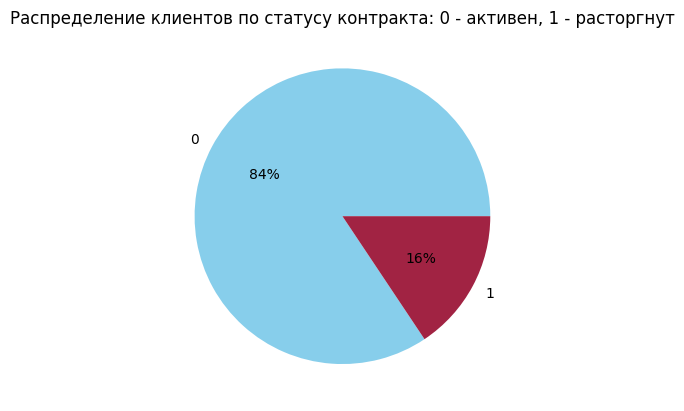

In [33]:
cutie_pie_chart('breakup_status', 'Распределение клиентов по статусу контракта: 0 - активен, 1 - расторгнут')

- Всего в датасете 16% расторгнутых контрактов. Расторгается приблизительно каждый 6-й контракт. Примем такую "текучку" клиентов за норму.
- Диспропорция очень сильная, но т.к. мы не уверены, насколько она нормальна + метрика модели к ней не чувствительна, мы не будем никак искусственно балансировать данные.
- Учтем дисбаланс при разделении выборки на тренеровочную и тестовую.

### Категориальные признаки в контексте целевого

Рассмотрим и визуализируем распределение следующих категориальных признаков в контексте целевого признака - активности или прекращения договора.
- Тип оплаты.
- Выставление электронного платежа.
- Метод оплаты.
- Пол клиента.
- Является ли клиент пенсионером.
- Брачный статус.
- Наличие детей.
- Подключение к нескольким телефонным линиям.
- Тип интернет-подключения.
- Подключение услуги блокировки опасных сайтов.
- Подключение к использованию облачного хранилища.
- Подключение услуги антивирус.
- Подключение к выделенному каналу техподдержки.
- Подключение услуги стримингового ТВ.
- Подключение каталога фильмов.

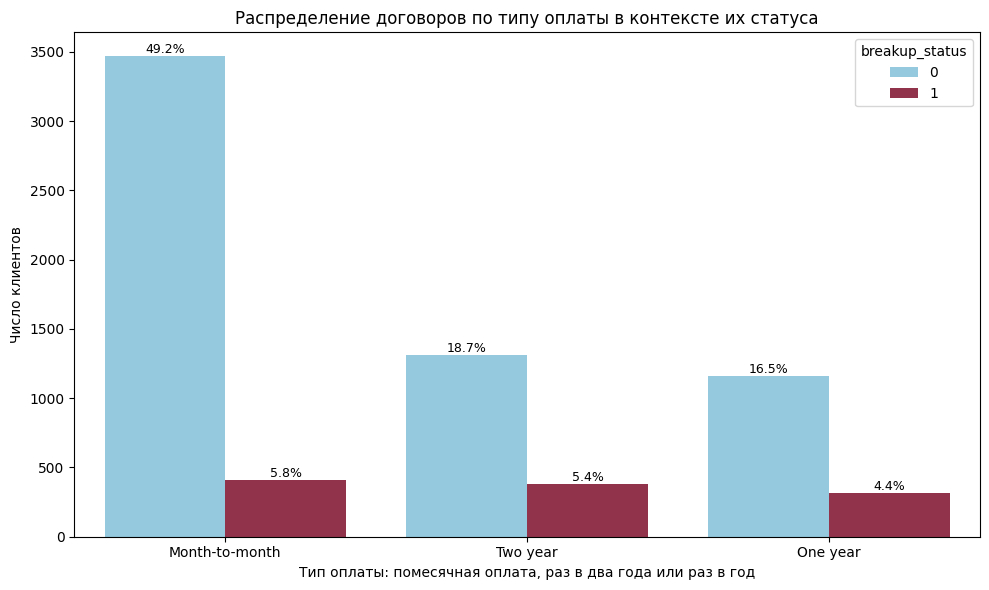

In [34]:
countplot_plot_for_cats('type', 'Распределение договоров по типу оплаты в контексте их статуса', 'Число клиентов', 'Тип оплаты: помесячная оплата, раз в два года или раз в год')

- 55% всех договоров - с помесячной оплатой. Наименее популярный тип, 20.9% - с оплатой раз в год.
- Для менее популярных типов договора - с оплатой раз в год и два, - вероятность разрыва значительно выше, чем для помесячной оплаты: в случае таких контрактов разрывается приблизительно каждый 5-й, а при помесячной - каждый 10-й.

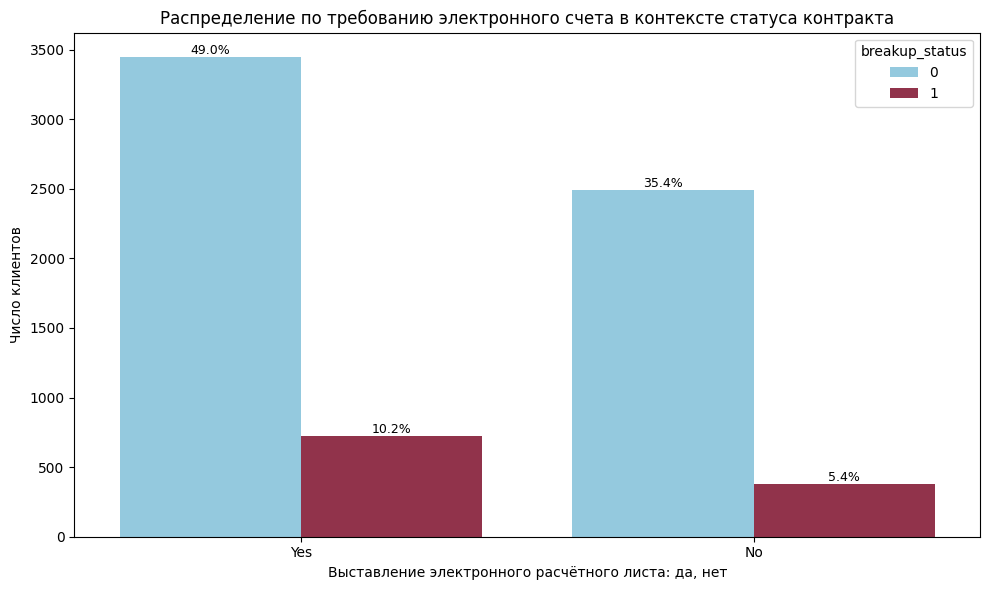

In [35]:
countplot_plot_for_cats('paperless_billing', 'Распределение по требованию электронного счета в контексте статуса контракта', 'Число клиентов', 'Выставление электронного расчётного листа: да, нет')

- 60% договоров предполагают выставление электронного счета, а в 40% - нет.
- В случаях электронного счета расторжение встречается незначительно чаще: каждый 6-й договор против каждого 8-го договора в случае счета без электронной версии.

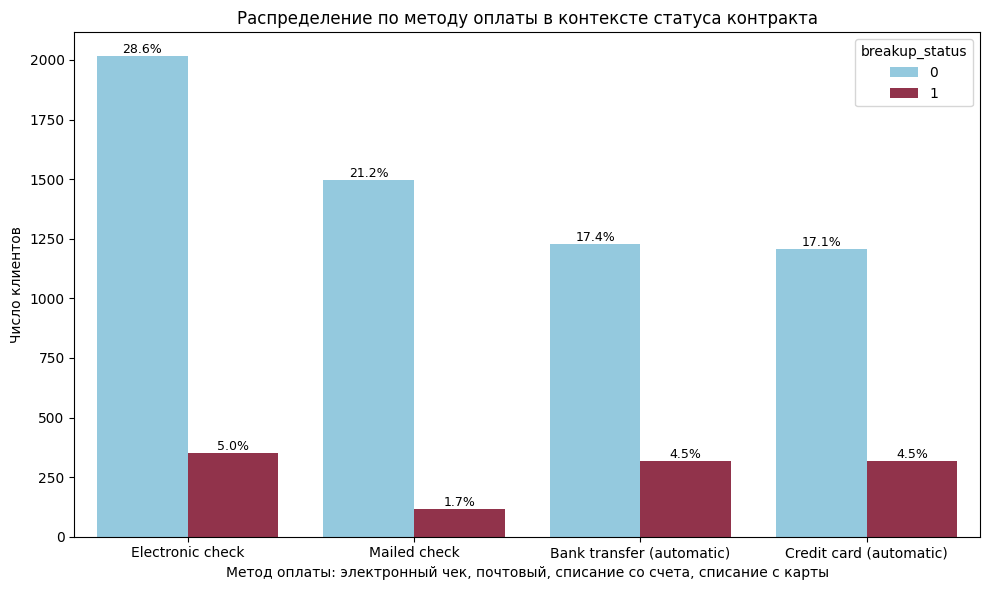

In [36]:
countplot_plot_for_cats('payment_method', 'Распределение по методу оплаты в контексте статуса контракта', 'Число клиентов', 'Метод оплаты: электронный чек, почтовый, списание со счета, списание с карты')

- Самый популярный тип - электронный счет, треть всех счетов. Наименее популярные типы - автоматические списания с карты и счета, по 22%.
- Заметно ниже число расторжений контракта в случае выставления счета на почту: в данной группе расторгается только каждый 13-й контракт, а в других группах - примерно каждый 5-й или 6-й. 

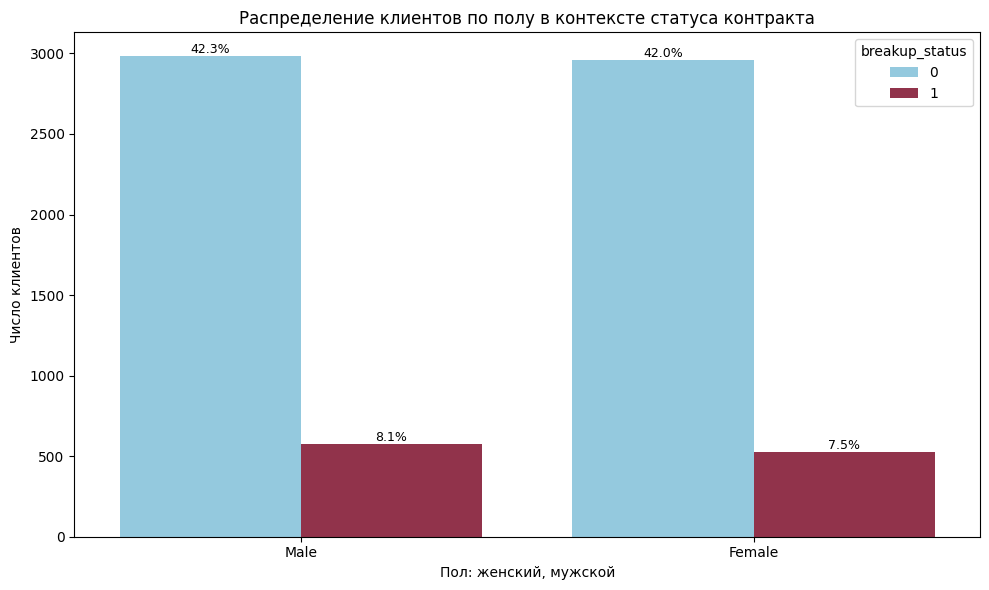

In [37]:
countplot_plot_for_cats('gender', 'Распределение клиентов по полу в контексте статуса контракта', 'Число клиентов', 'Пол: женский, мужской')

- Число клиентов примерно равное по полу.
- Вероятность расторжения от пола также мало зависит.

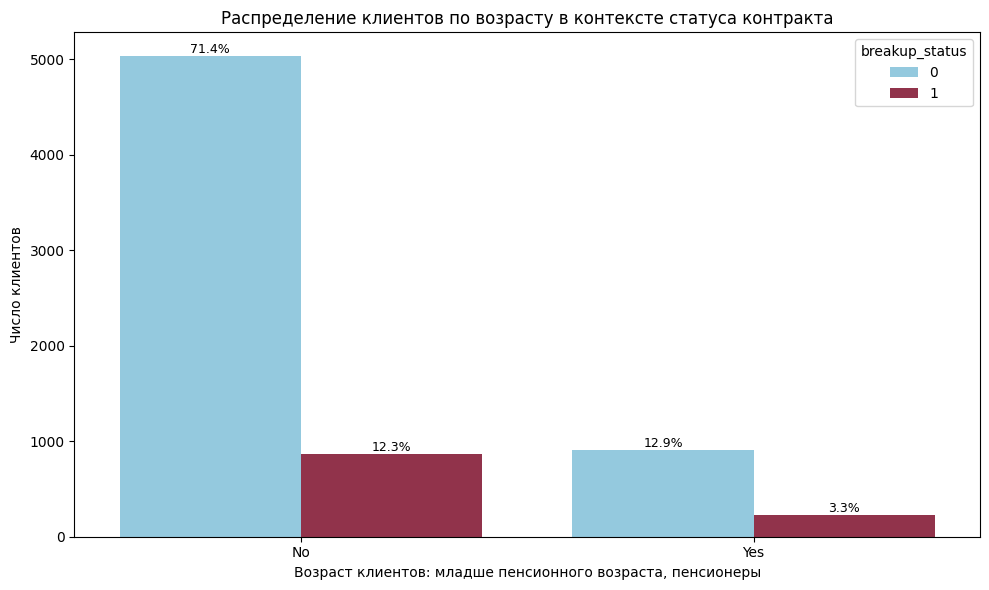

In [38]:
countplot_plot_for_cats('senior_citizen', 'Распределение клиентов по возрасту в контексте статуса контракта', 'Число клиентов', 'Возраст клиентов: младше пенсионного возраста, пенсионеры')

- 83.7% клиентов - младше пенсионного возраста.
- Статистика расторжения контрактов приблизительно одинаковая для обеих категорий.

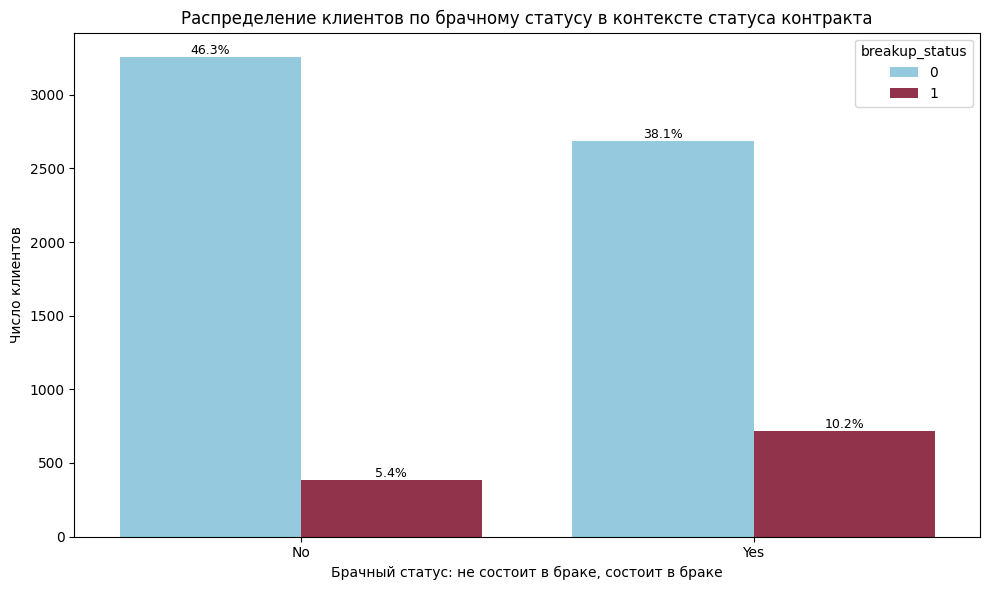

In [39]:
countplot_plot_for_cats('partner', 'Распределение клиентов по брачному статусу в контексте статуса контракта', 'Число клиентов', 'Брачный статус: не состоит в браке, состоит в браке')

- Число клиентов в браке и не в браке приблизительно равное.
- Клиенты в браке вдвое чаще прекращают контракт: среди них прекращается каждый 5-й контракт, а среди клиентов не в браке - каждый 10-й.

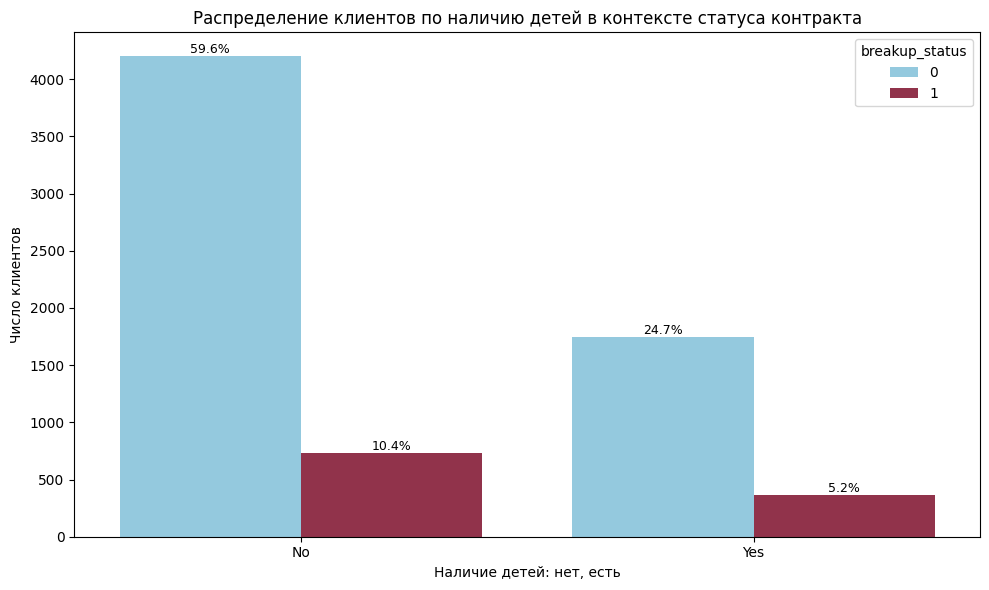

In [40]:
countplot_plot_for_cats('dependents', 'Распределение клиентов по наличию детей в контексте статуса контракта', 'Число клиентов', 'Наличие детей: нет, есть')

- У 71% клиентов детей нет.
- Клиенты с детьми ну очень незначительно чаще парекращают контракт: каждый 6-й против каждого 7-го у клиентов без детей.

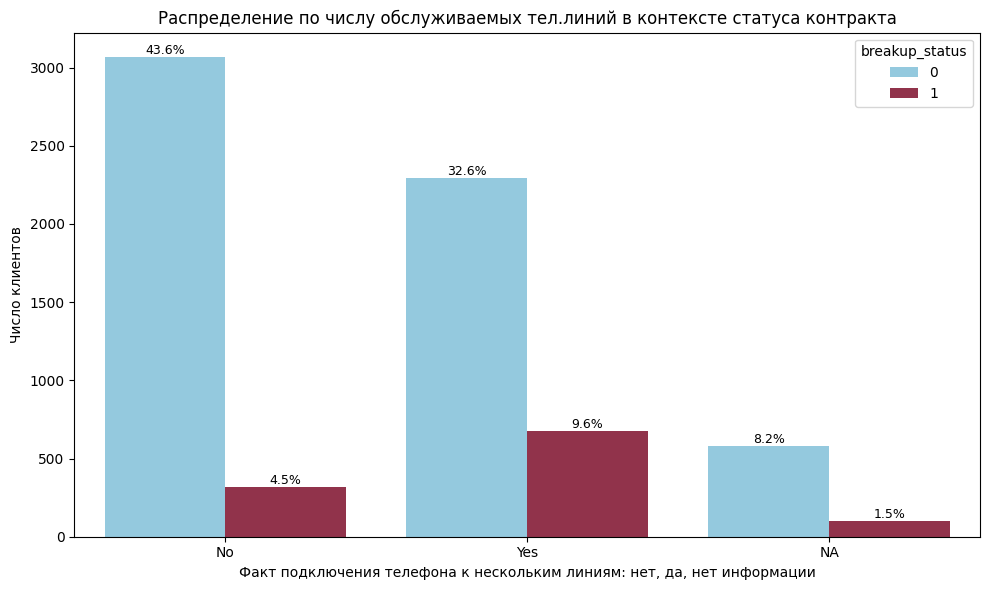

In [41]:
countplot_plot_for_cats('multiple_lines', 'Распределение по числу обслуживаемых тел.линий в контексте статуса контракта', 'Число клиентов', 'Факт подключения телефона к нескольким линиям: нет, да, нет информации')

- Почти у половины клиентов телефон подключен только к одной линии. Самая малочисленная категория - клиенты, число линий у которых не известно, 9.7%.
- Заметно чаще контракт разрывают клиенты, подключенные к нескольким линиям: в их случае разрывается каждый 4-й контракт.

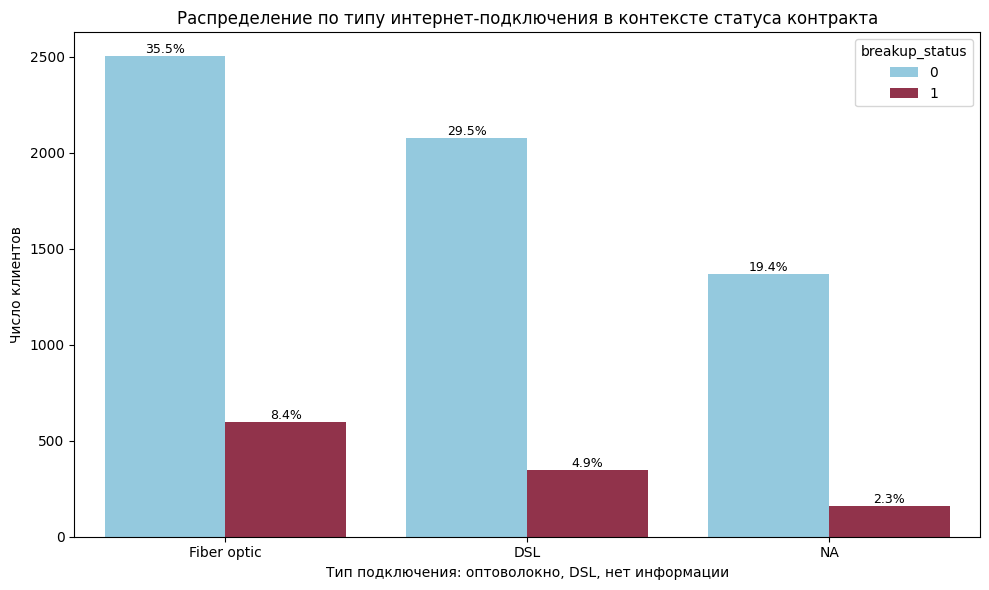

In [42]:
countplot_plot_for_cats('internet_service', 'Распределение по типу интернет-подключения в контексте статуса контракта', 'Число клиентов', 'Тип подключения: оптоволокно, DSL, нет информации')

- Самый распространенный тип подключения - оптоволоконный, он у 43.9% клиентов. У 34.4% DSL-подключение, у остальных - неизвестно.
- Клиенты с оптоволоконным подключением разрывают контракт заметно чаще, чем в других группах клиентов. Особенно по сравнению с клиентами, чей тип подкючения неизвестен.

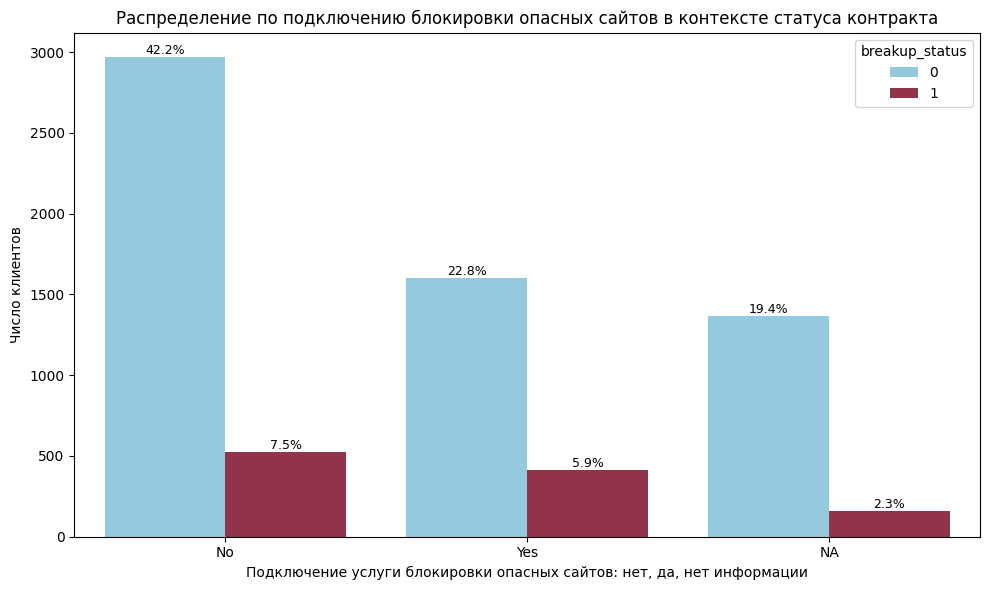

In [43]:
countplot_plot_for_cats('online_security', 'Распределение по подключению блокировки опасных сайтов в контексте статуса контракта', 'Число клиентов', 'Подключение услуги блокировки опасных сайтов: нет, да, нет информации')

- Половина клиентов не пользуется услугой блокировки опасных сайтов, 28.7% пользуются, статус остальных клиентов - неизвестен.
- Клиенты с подключенной услугой блокировки расторгают контракты незначительно реже, однако самая низкая доля расторгнутых контрактов - среди группы, чей статус подключения услуги (равно как и интернет-услуг вообще) неизвестен.

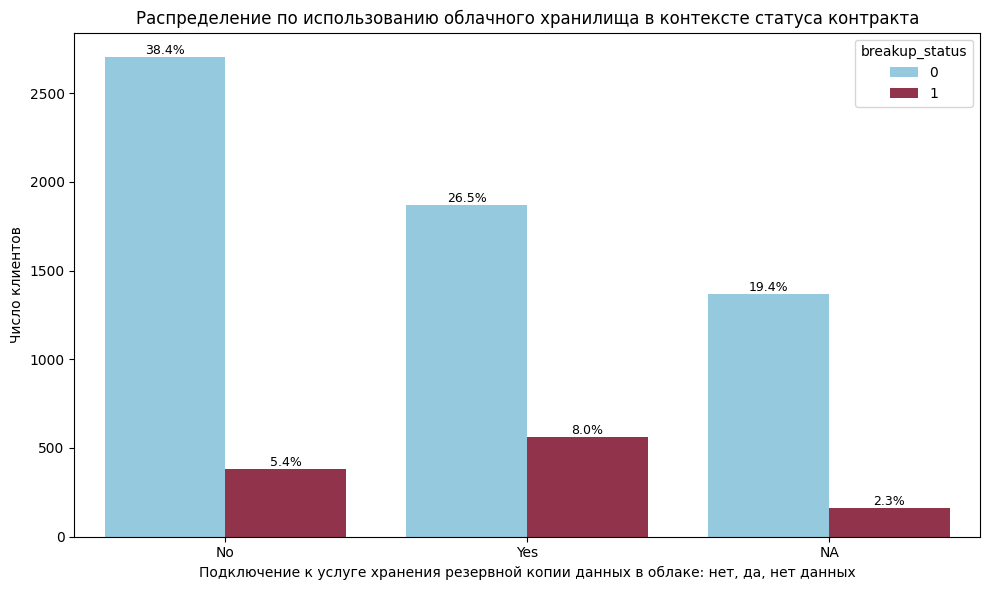

In [44]:
countplot_plot_for_cats('online_backup', 'Распределение по использованию облачного хранилища в контексте статуса контракта', 'Число клиентов', 'Подключение к услуге хранения резервной копии данных в облаке: нет, да, нет данных')

- 43.8% клиентов не пользуются облаком, 34.5% пользуются, статус остальных - неизвестен.
- Заметно выше доля расторжений среди абонентов, пользовавшихся облачным хранилищем.

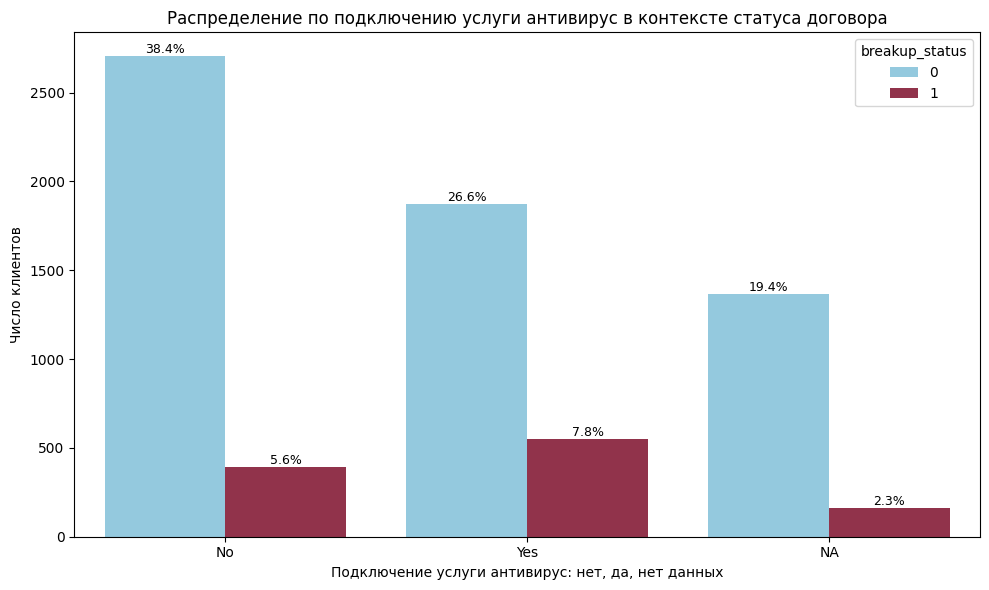

In [45]:
countplot_plot_for_cats('device_protection', 'Распределение по подключению услуги антивирус в контексте статуса договора', 'Число клиентов', 'Подключение услуги антивирус: нет, да, нет данных')

- 44% процента не подключали услугу антивирус, 34.4% поключили, статус остальных - неизвестен.
- Опять же, доля расторжений контракта заметно выше у пользователей сервиса в сравнении с другими группами.

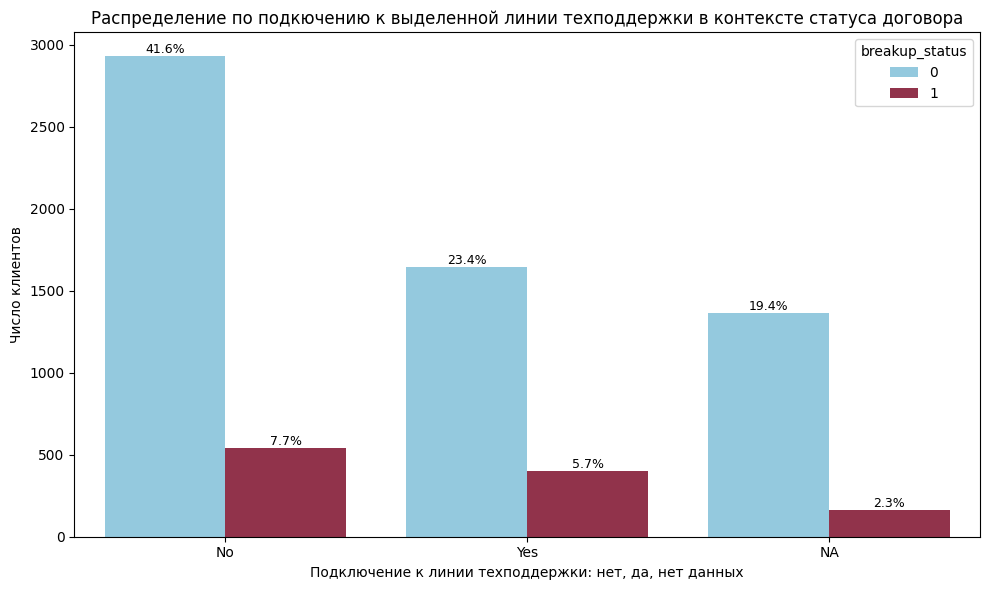

In [46]:
countplot_plot_for_cats('tech_support', 'Распределение по подкючению к выделенной линии техподдержки в контексте статуса договора', 'Число клиентов', 'Подключение к линии техподдержки: нет, да, нет данных')

- 49.3% клиентов не подключали линию техподдержки, 29.1% подключили, статус остальных - неизвестен.
- Как и в случае почти со всеми интернет-сервисами, доля разрывов контрактов выше среди их пользователей, чем среди других клиентов.

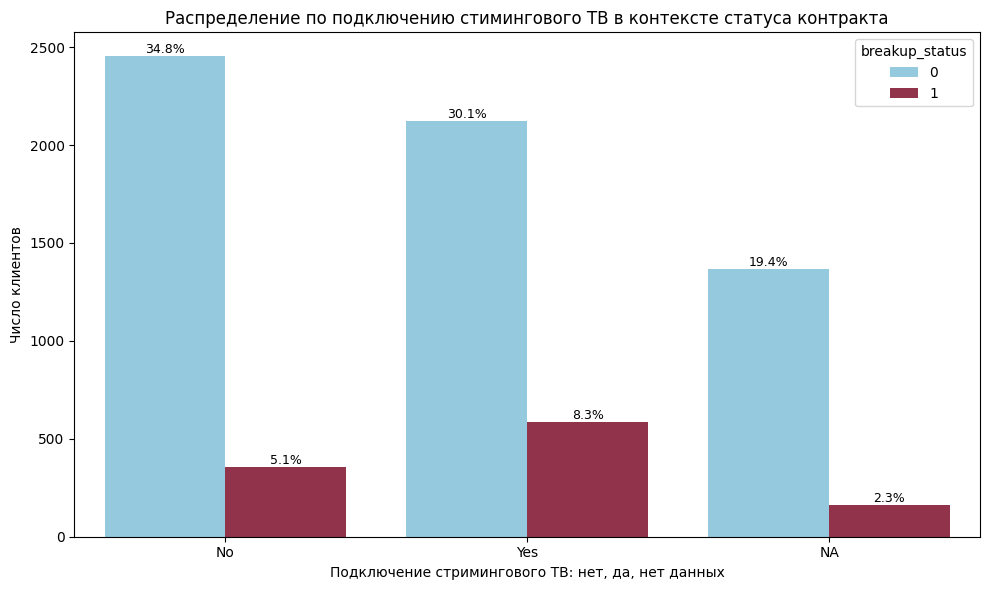

In [47]:
countplot_plot_for_cats('streaming_tv', 'Распределение по подключению стимингового ТВ в контексте статуса контракта', 'Число клиентов', 'Подключение стримингового ТВ: нет, да, нет данных')

- 39.9% клиентов не подключали стриминговое ТВ, 38.4% подключали, статус остальных - неизвестен.
- Число разрывов контракта заметно выше среди пользователей сервиса стримингового ТВ, чем в других группах.

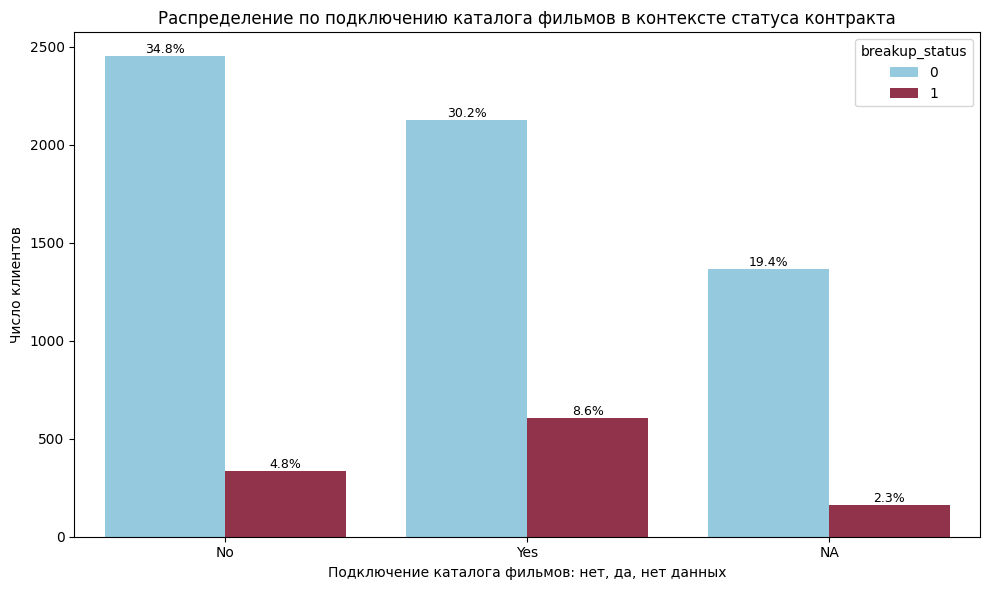

In [48]:
countplot_plot_for_cats('streaming_movies', 'Распределение по подключению каталога фильмов в контексте статуса контракта', 'Число клиентов', 'Подключение каталога фильмов: нет, да, нет данных')

- 39.6% клиентов не подключали сервис, 38.8% подключали, остальные - неизвестно.
- Доля расторжений среди пользователей услуги вдвое выше, чем среди тех, кто ее не подключал. 

### Количественные признаки в контексте целевого

Рассмотрим и визуализируем распределение следующих количественных признаков в контексте целевого признака - активности или прекращения договора.
- Размер ежемесячного платежа.
- Размер общих расходов абонента.
- Продолжительность действия контракта.

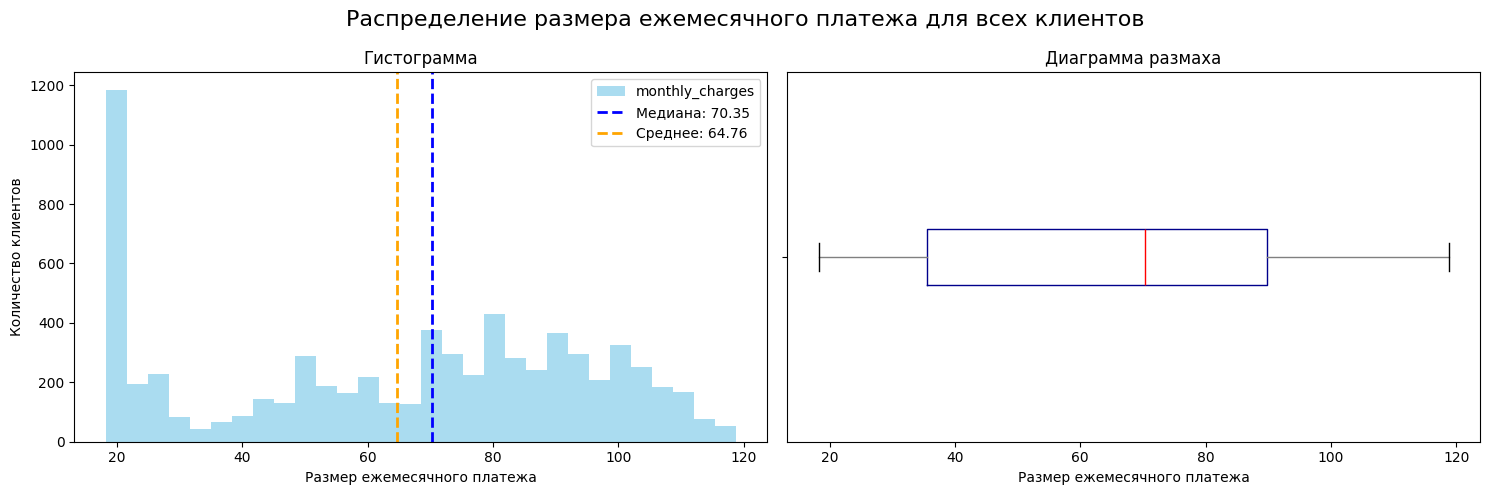

In [49]:
hist_and_box_chart('monthly_charges', 'Распределение размера ежемесячного платежа для всех клиентов', 'Размер ежемесячного платежа', 30)

- В целом среди всех клиентов наблюдается большое количество абонентов (примерно 20% всех абонентов), подключенных к тарифу с минимальным платежом 20.
- Помимо большой группы с подключением к минимальному абонентскому пакету, распределение ежемесячных трат для всех пользователей равномерное, в диапазоне от 20 до 120.
- Выбросы не наблюдаются, в целом картина выглядит адекватной.

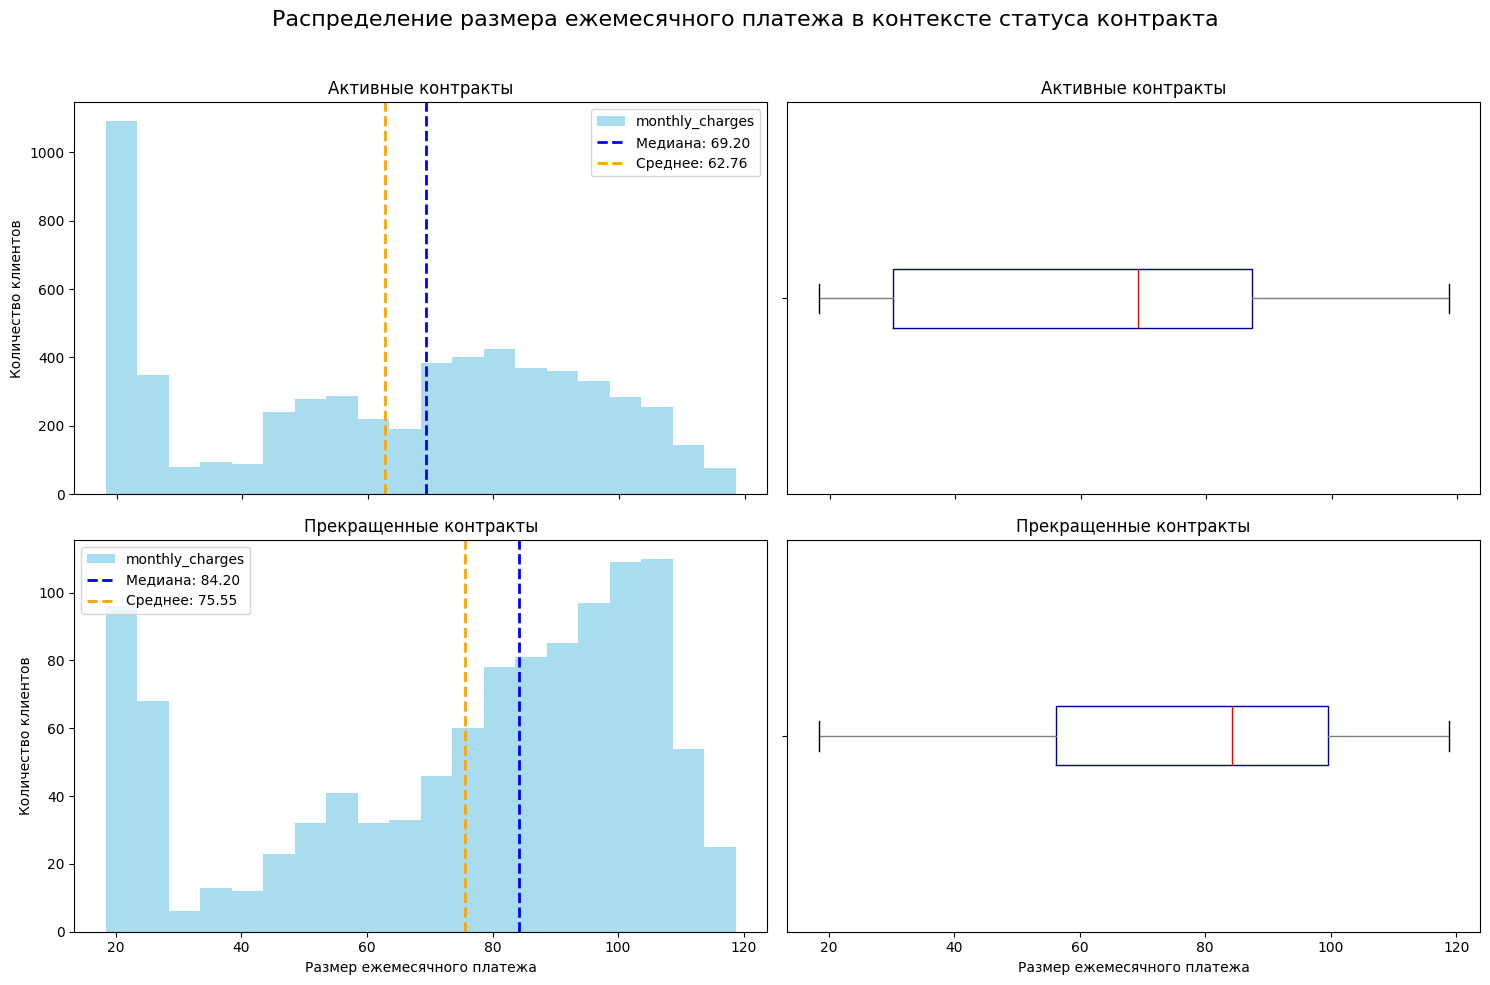

In [50]:
hist_for_two('Распределение размера ежемесячного платежа в контексте статуса контракта', 'monthly_charges', 'Размер ежемесячного платежа')

- При сравнительном анализе заметно, что клиенты, прекратившие контракт, вносили заметно большую сумму ежемесячно.
- Медианный платеж текущих клиентов на 15 ниже, чем у ушедших.
- В целом распределение для бывших клиентов имеет заметную левостороннюю ассиметрию (помимо группы минимального тарифа).

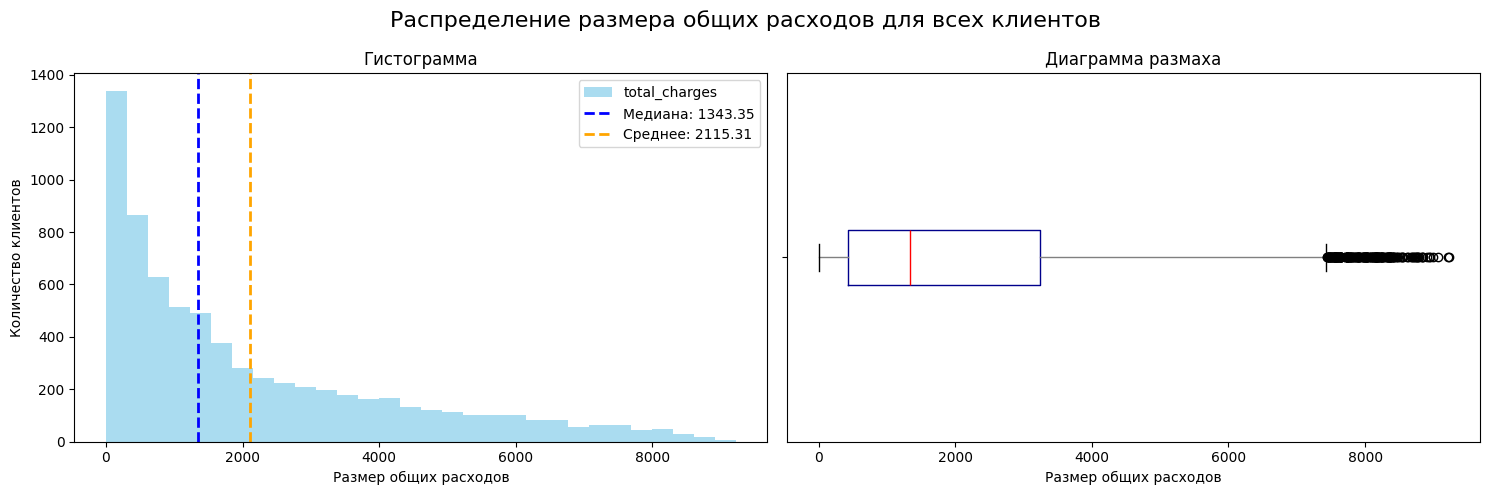

In [51]:
hist_and_box_chart('total_charges', 'Распределение размера общих расходов для всех клиентов', 'Размер общих расходов', 30)

In [52]:
print('Средний размер платежа среди клиентов с общим счетом больше 7000:', round(data.query('total_charges > 7000')['monthly_charges'].mean(), 2))
print('Средняя продолжительность действия контракта среди клиентов с общим счетом больше 7000:', round(data.query('total_charges > 7000')['duration_days'].mean(), 2))

Средний размер платежа среди клиентов с общим счетом больше 7000: 108.15
Средняя продолжительность действия контракта среди клиентов с общим счетом больше 7000: 2124.69


- График общих расходов для всех клиентов имеет ожидаемую форму: плавное уменьшение от большого числа клиентов с небольшими общими расходами к длинному хвосту огромных счетов.
- Хвост аномалий с огромными счетами в целом объясним: это прекрасные люди, которые уже больше 5 лет каждый месяц платят компании почти вдвое больше, чем средний потребитель.

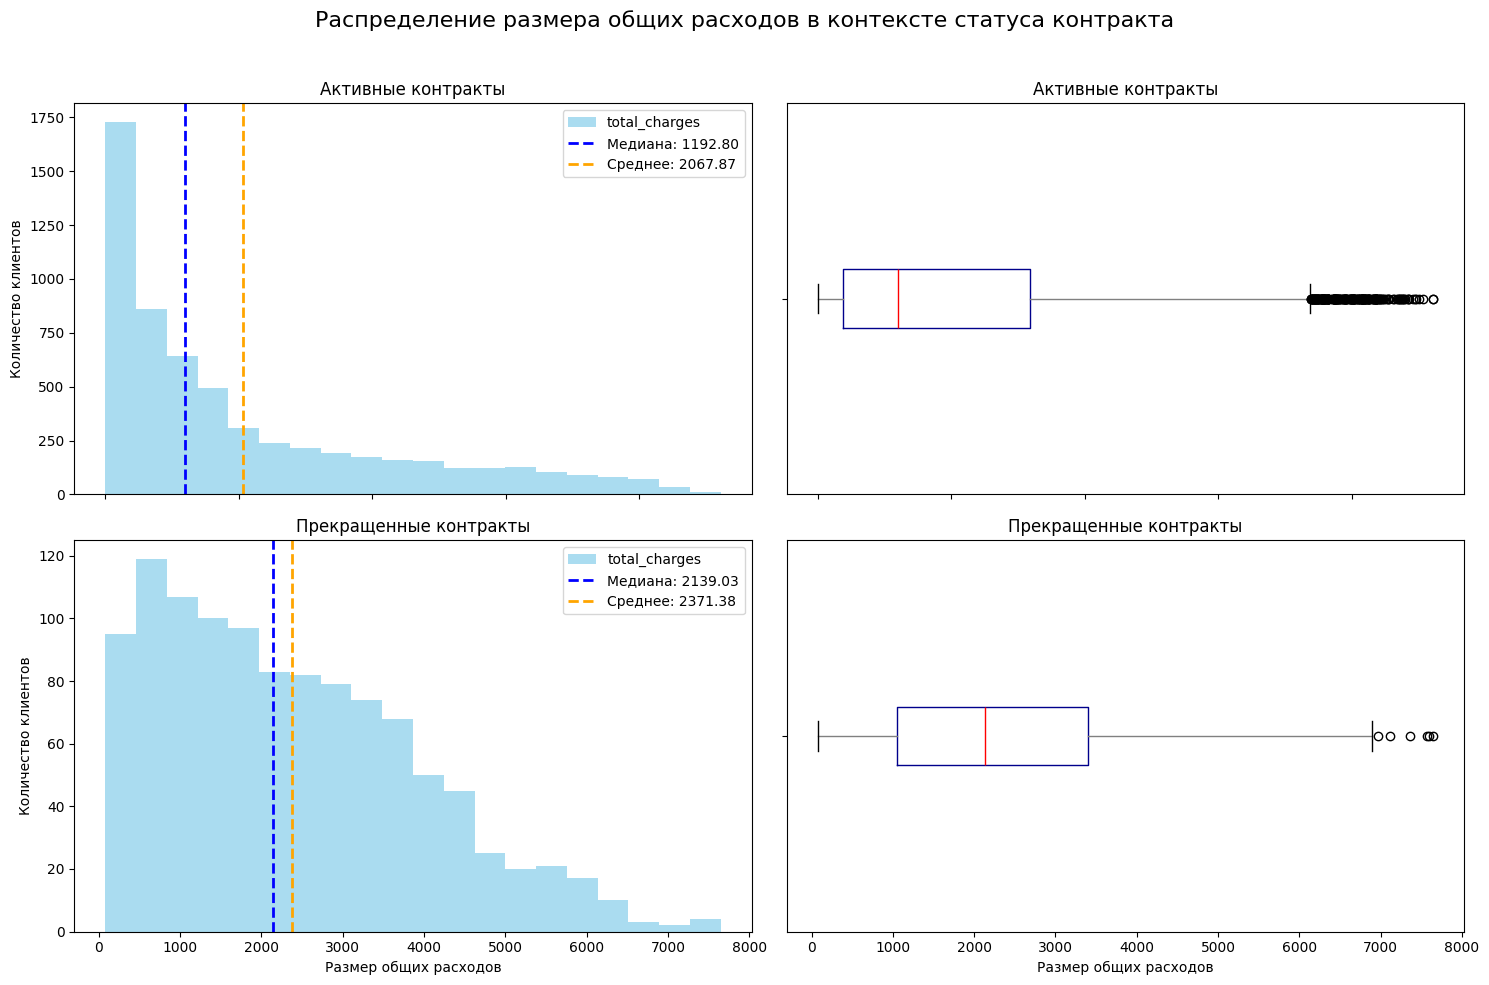

In [53]:
hist_for_two('Распределение размера общих расходов в контексте статуса контракта', 'total_charges', 'Размер общих расходов')

- Как можно было ожидать из сравнения месячных платежей, общий платеж у клиентов, расторгнувших контракт, также заметно выше.
- Медиана среди клиентов, расторгнувших контракт, выше почти вдвое: 2139 у бывших клиентов против 1192 у текущих.
- Верхняя граница боксплота у расторгнувших контракт также заметно выше: для них большие счета были нормой.

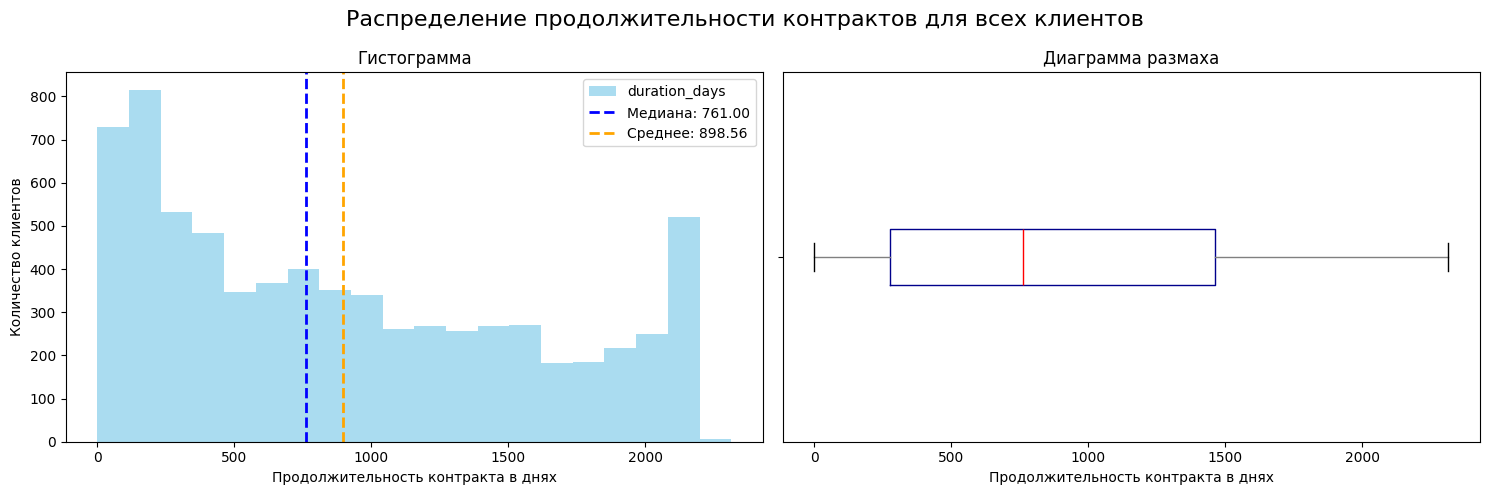

In [54]:
hist_and_box_chart('duration_days', 'Распределение продолжительности контрактов для всех клиентов', 'Продолжительность контракта в днях', 20)

- В общей массе клиентов заметны два пика по краям: очень заметна доля "новичков", которые пользуются услугами меньше года, и лояльных клиентов, которые остаются с компанией по 5 лет и более.
- Средний клиент пользуется услугами компании около 2 лет.

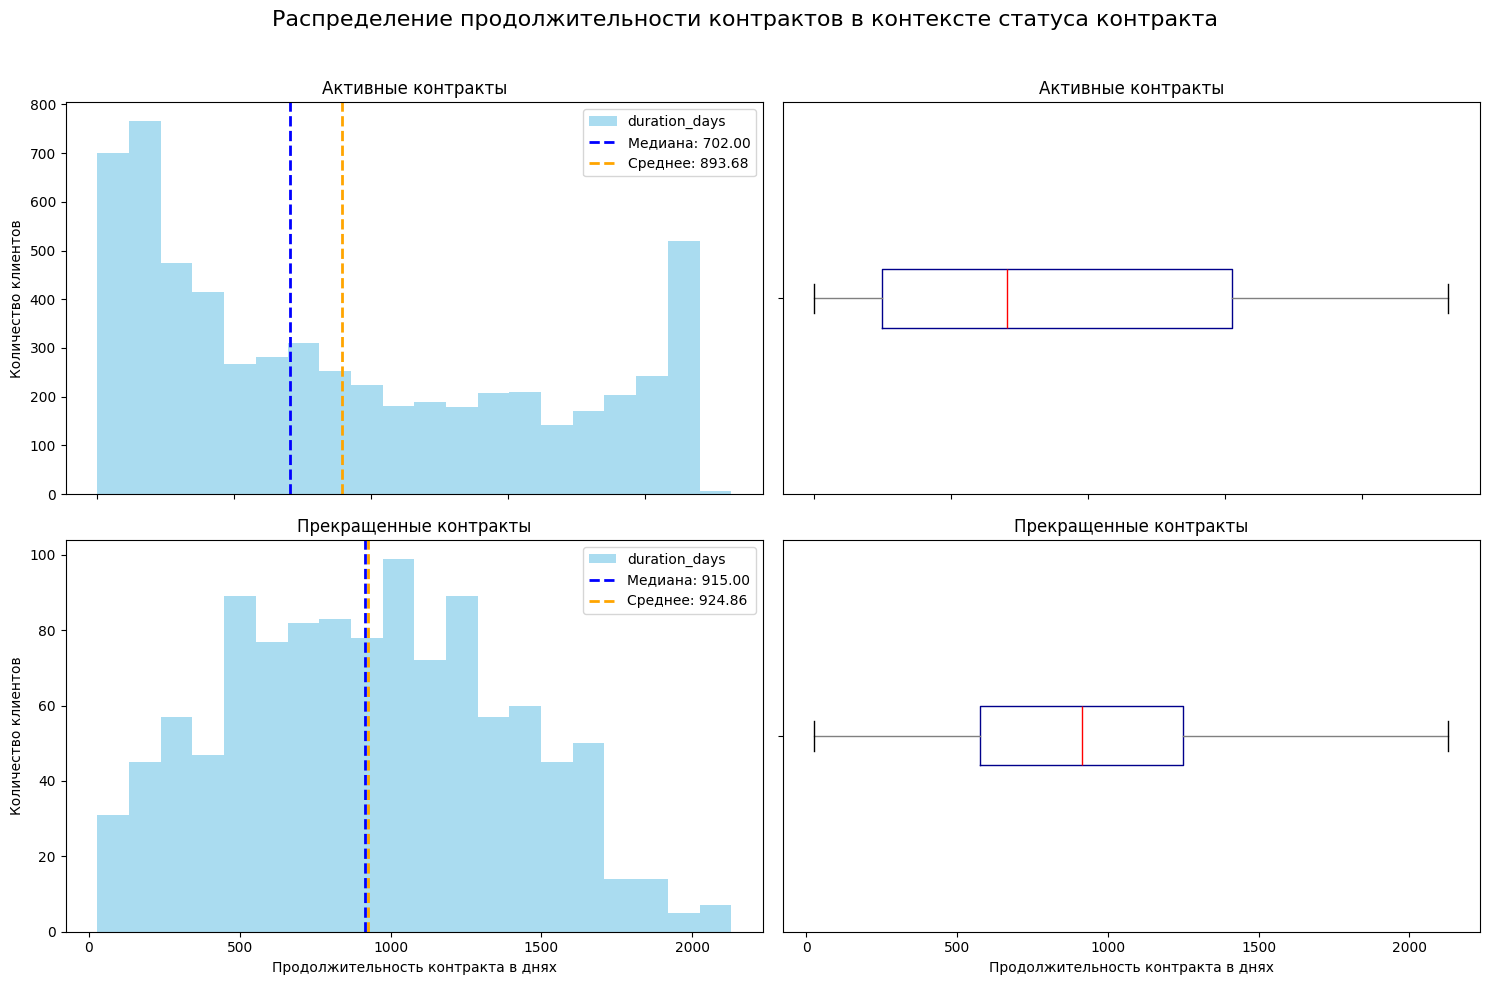

In [55]:
hist_for_two('Распределение продолжительности контрактов в контексте статуса контракта', 'duration_days', 'Продолжительность контракта в днях')

- Формы графиков продолжительности контрактов для активных и бывших клиентов почти противоположны: если среди текущих много новичков и оч лояльных клиентов, то ушедшие - середнячки между 1.5 и 3 годами с компанией.
- На боксплоте также заметна обозначенная тенденция: основная масса значений гораздо компактнее сконцентрирована вокруг средних значений.

### Выводы по исследовательскому анализу

- Наблюдается сильный дисбаланс для целевого признака, что мы учтем при делении данных на тренеровочную и тестовую выборки.
- Почти всегда вероятность разрыва контракта выше в связи с большей погруженностью клиентов в продукт - и, вероятно, увеличением платежа в этой связи: среди тех, кто достоверно пользовался специфицическими интернет-услугами или имел несколько телефонных линий, доля расторжений стабильно выше обычного.
- Другими категориальными признаками, связанными с бОльшей долей расторжений, являются наличие брачного партнера и получение счета почтой, но здесь связь в лучшем случае через какой-то сторонний признак, а в худшем случае - это просто совпадение.
- Клиенты также демонстрируют заметную чувствительность к цене услуг: высокие ежемесячные и общие расходы более характерны для клиентов, решивших расторгнуть контракт (кроме небольшой группы оч лояльных премиум-потребителей).
- На чувствительность к цене также указывает значительно меньшая доля расторжений среди клиентов с помесячной оплатой: единоразовый платеж за год-два с большей вероятностью будет ощущаться как большой или, как минимум, как повод задуматься.
- Самый вероятный период расторжения контракта - на сроке от 1.5 до 3 лет использования услуг.

## Корреляционный анализ

### Матрица корреляции

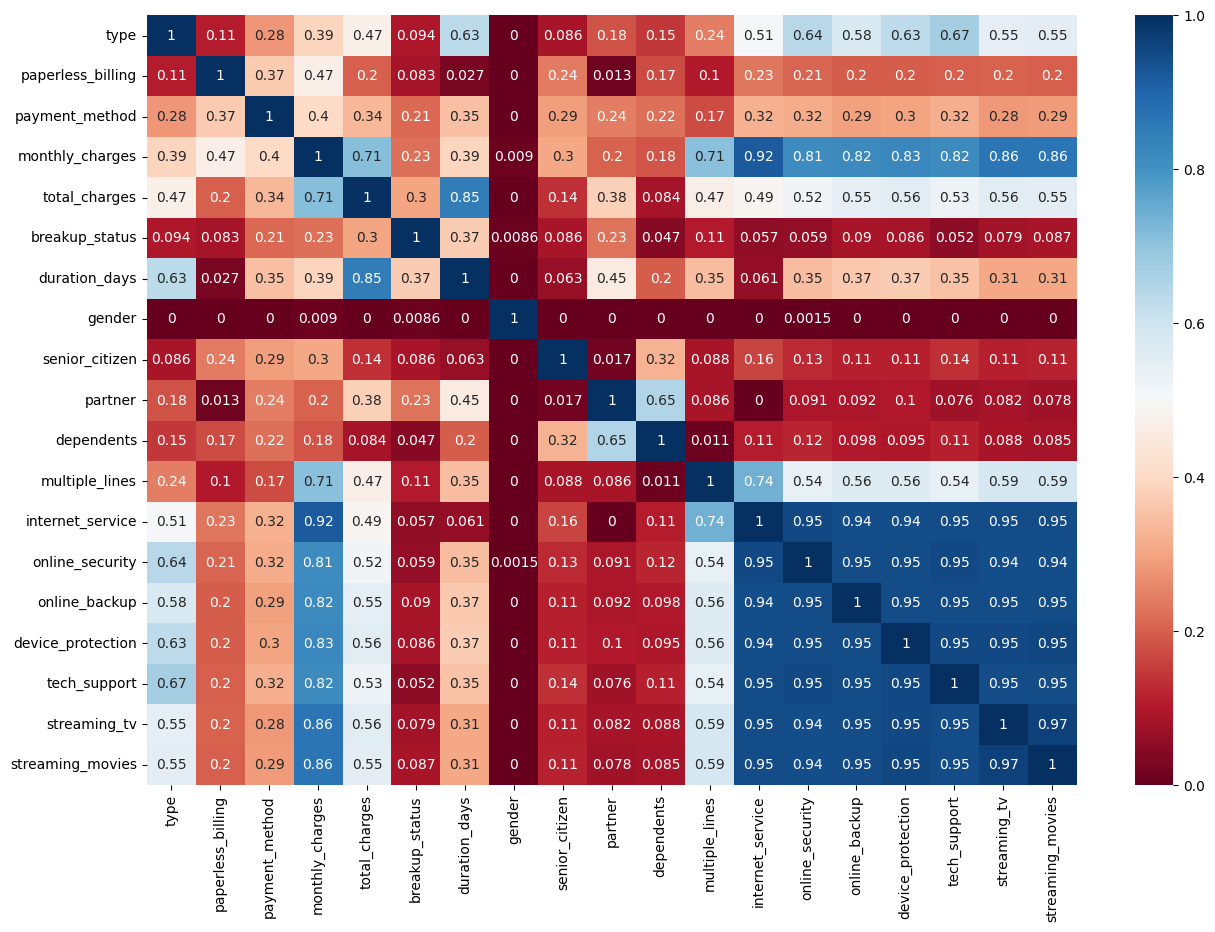

In [56]:
plt.figure(figsize=(15, 10))
#целевой признак статус контракта у нас сейчас является числовым по типу данных, но по сути, разумеется, является категориальным
interval_cols = ['monthly_charges', 'total_charges', 'duration_days']
sns.heatmap(data.drop('customer_id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='RdBu');

- Сильнее всего (хотя и не выраженно) со статусом контракта коррелируют следующие признаки, в порядке убывания корреляции: продолжительность контракта, общие расходы абонента, размер ежемесячного платежа и наличие супругов, метод платежа.
- Все признаки, связанные с использованием дополнительных интернет-сервисов, имеют сильную мультиколинеарность. Хотя в смысле качества прогноза она опасна только для линейной регрессии, она очень пагубна для интерпретируемости и времени работы модели. Плюс, сомнительна идея привязывать работу модели к конкретным (и быстро морально устаревающим) сервисам. Лучше создать на их базе самостоятельный признак - подключение дополнительных интернет-сервисов.


In [57]:
#создадим обобщающий признак 'additional_internet_services' вместо 6 мультиколинеарных признаков с указанием на конкретные сервисы
cols = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

data['additional_internet_services'] = data[cols].apply(
    lambda row:('No' if all(r == 'No' for r in row) 
                else 'NA' if all(r == 'NA' for r in row) 
                else 'Yes'), axis=1)

data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,breakup_status,duration_days,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,additional_internet_services
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,...,No,NA,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,...,No,No,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,...,No,No,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,...,No,NA,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,...,No,No,Fiber optic,No,No,No,No,No,No,No


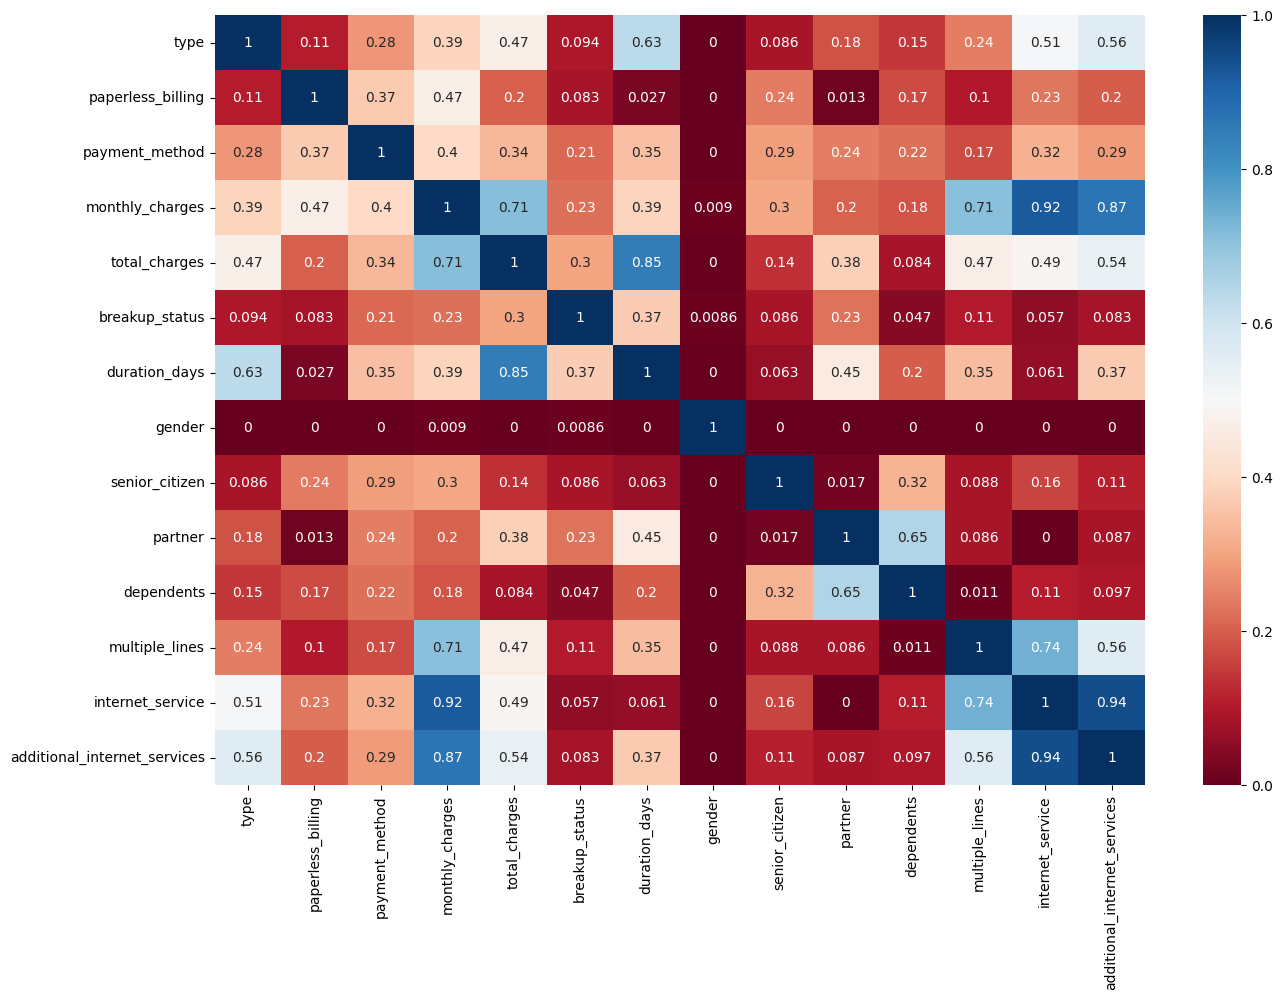

In [58]:
plt.figure(figsize=(15, 10))
#целевой признак статус контракта у нас сейчас является числовым по типу данных, но по сути, разумеется, является категориальным
interval_cols = ['monthly_charges', 'total_charges', 'duration_days']
sns.heatmap(data.drop(['customer_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='RdBu');

- Признак с типом интернет-подключения все еще мультиколинеарен признаку месячного платежа и наличию допсервисов. Однако, мы его пока оставим, потому что мешать мультиколинеарность может только регрессии. Плюс, в реальности связь типа подключения с патежом и сервисами может быть не такой сильной. (Например, если бы в датасете было больше *реальных* типов подключения со схожей ценой, или исходные данные были бы лучше скоординированы - сейчас значение NA в internet_service это автоматическое NA и в допсервисах.)
- Общие затраты не имеют формально мультиколинеарности, но они - по сути производная ежемесячных затрат и длительности контракта (с минимальной погрешностью). Хотя общие затраты более полный финансовый признак в контексте всей клиентской истории, именно месячные затраты в данном случае отражают актуальную финансовую нагрузку на абонента. Чтобы не рассеивать внимание модели между двумя важными, но по большому счету дублирующими финансовыми признаками, мы один - общие затраты, как менее актуальный - удалим.
- Из группы "шумных" категориальных признаков с корреляцией меньше 0.1 мы оставим только те, которые выглядели перспективно при исследовательском анализе: метод оплаты, тип оплаты, тип интернет-подключения.

### Выводы из корреляционного анализа

- Сильнее всего (хотя и не выраженно) со статусом контракта коррелируют следующие признаки, в порядке убывания корреляции: продолжительность контракта, общие расходы абонента, размер ежемесячного платежа и наличие супругов, метод платежа.
- Мультиколинеарные признаки с конкретными дополнительными интернет-сервисами были заменены на один признак - наличие подключений к дополнительным интернет-сервисам.
- Хотя признак с типом интернет-подключения все еще мультиколинеарен признаку месячного платежа и наличию допсервисов, мы его сохранили, т.к. он большинству моделей даже потенциально не помеха и в реальности может быть более полезен, чем в конкретных данных.
- Общие затраты мы удалили, как "дублирующий" финансовый признак в условиях наличия ежемесячных затрат и общей длительности контракта.
- Из группы "шумных" категориальных признаков с корреляцией меньше 0.1 мы оставим только те, которые выглядели перспективно при исследовательском анализе: метод оплаты, тип оплаты, тип интернет-подключения.
_____

**Финальный список входных признаков для разработки и выбора модели**
- Тип контракта по регулярности платежа
- Метод оплаты
- Текущий размер ежемесячных затрат
- Продолжительность контракта
- Наличие у клиента супруга
- Подключение нескольких телефонных линий
- Тип интернет-подключения
- Подписка на дополнительные интернет-сервисы

## Модель прогноза прекращения контракта

#### Создание пайплайна

Создадим модель обучения с учителем для задачи классификации, целью которой является прогноз целевого признака - прекращение контракта.

- Создадим пайплайн для теста 3 моделей: CatBoostClassifier(), LogicsticRegression(), KNeighborsClassifier().
- Применим метрику ROC-AUC.
- Проанализируем работу моделей.

In [59]:
#выделим целевой признак и входные данные
X = data.drop(['breakup_status', 'customer_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'gender', 'senior_citizen', 'dependents', 'total_charges'], axis=1)
y = data['breakup_status']

#разделим на тренировочный и тестовый наборы данных с учетом дисбаланса целевого признака
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

#проверим размеренность
print('Размеренность датасета с входными данными:', X.shape[0], X.shape[1])
print('Размеренность датасета с тренеровочными данными:', X_train.shape[0], X_train.shape[1])
print('Размеренность датасета с тестовыми данными:', X_test.shape[0], X_test.shape[1])

Размеренность датасета с входными данными: 7043 8
Размеренность датасета с тренеровочными данными: 5282 8
Размеренность датасета с тестовыми данными: 1761 8


In [60]:
#создаём списки с названиями признаков: категориальные и числовые признаки
ohe_columns = ['type', 'payment_method', 'partner', 'multiple_lines', 'internet_service', 'additional_internet_services']
num_columns = ['monthly_charges', 'duration_days']

#создаём пайплайн подготовки категориальных признаков: заполнение пропусков, если вдруг такие случайно будут, и OHE-кодирование
#хотя CatBoost умеет сама в категориальные признаки, в данном конкретном случае это у нее получалось не очень, а код, доказывабщий это, был долгий и с небоскреб
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
    )

#создаём общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier())
])

param_grid = [
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, n_estimators=1000, verbose=0)],
        'models__max_depth': range(2, 8),
        'models__learning_rate': [0.1, 0.15, 0.25, 0.5]

    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(max_iter=500)],
        'models__C': [0.1, 1.0, 10.0]
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7]
    }]

#используем случайный поиск, чтобы успеть до дедлайна
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)
random_search.fit(X_train, y_train)

print('Параметры лучшей модели:', random_search.best_params_)
print('')
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Параметры лучшей модели: {'models__max_depth': 2, 'models__learning_rate': 0.25, 'models': <catboost.core.CatBoostClassifier object at 0x000001CEDC73C670>}

Метрика лучшей модели на тренировочной выборке: 0.9269019892753801


In [61]:
prob = random_search.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC лучшей модели на тестовой выборке:', roc_auc_score(y_test, prob))

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9450911537990945


### Анализ работы лучшей модели

В рамках анализа модели мы оценим следующие параметры:
- Качество работы самой модели: полноту и точность выявления случаев разрыва.
- Признаки, которые оказались важными для работы модели - и которые могут указывать на группы риска и слабости продукта в целом.

#### Качество модели

Accuracy: 0.945
Precision: 0.937
Recall: 0.698



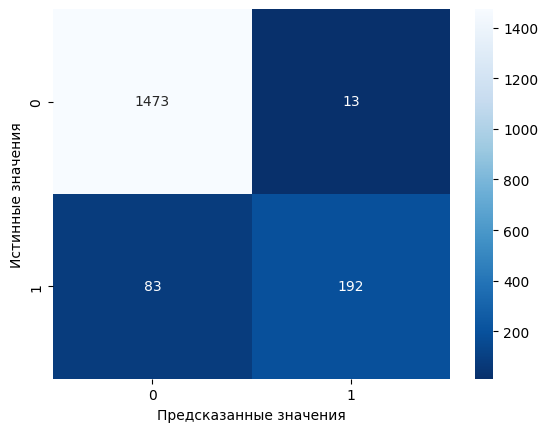

In [62]:
#посмотрим, где и как модель ошибается
prediction = random_search.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('') 

cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show;

- В целом у модели хорошие показатели Accracy, Precision и Recall.
- Модель в текущем виде точно не разорит клиента на раздаче лишних промокодов - она делает всего 13 ошибок первого типа, т.е. предсказывает разрыв контракта в случае его сохранения.
- Модель в текущем виде пропускает примерно каждый третий разрыв контракта - она делает 83 ошибки второго типа, т.е. предсказывает сохранение контракта в случае его разрыва.
- Более полное выявление случаев разрыва возможно при корректировке порога модели.

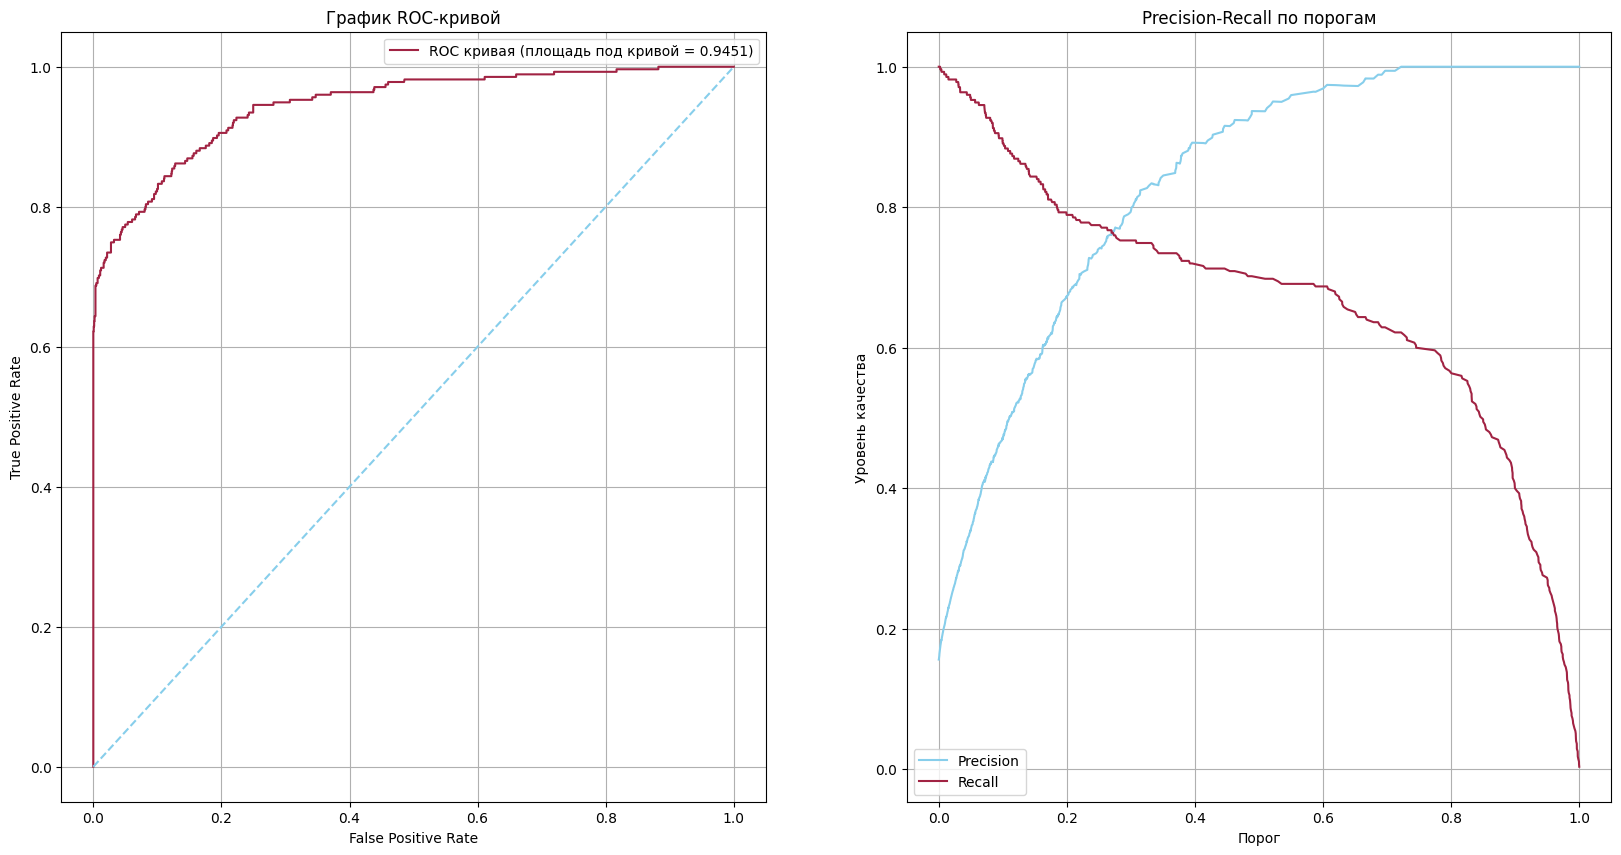

In [63]:
#посмотрим, на каком пороге модель уверенно классифицирует прекращение контракта
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

fpr, tpr, treshold = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='#A12343', label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='#87CEEB', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('График ROC-кривой')

precision, recall, thresholds = precision_recall_curve(y_test, prob)

axes[1].plot(thresholds, precision[:-1], label='Precision', color='#87CEEB')
axes[1].plot(thresholds, recall[:-1], label='Recall', color='#A12343')
axes[1].set_ylabel('Уровень качества')
axes[1].set_xlabel('Порог')
axes[1].legend()
axes[1].grid(True)
axes[1].set_title('Precision-Recall по порогам')

plt.show()

- Модель совершенно точно предсказывает лучше, чем случайное угадывание: график ROC-кривой уходит вверх от диагонали случайного результата.
- Поскольку у нас наблюдается сильный дисбаланс, куда интереснее график соотношения полноты и точности. Если бюджет промо позволяет более активную профилактику разрывов, то с коррекцией порога примерно с 0.5 на 0.6 мы получаем точность выявления разрывов около 98% без заметных потерь для обобщающей способности модели.

#### Важность признаков

In [64]:
#анализ важности признаков
pd.DataFrame(
    random_search.best_estimator_[-1].feature_importances_, 
    index=random_search.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

,Важность признака
num__duration_days,75.668497
num__monthly_charges,12.354021
ohe__type_Month-to-month,4.166828
ohe__payment_method_Mailed check,1.733014
ohe__type_Two year,1.137926
ohe__partner_Yes,1.016521
ohe__multiple_lines_No,0.964566
ohe__partner_No,0.668859
ohe__payment_method_Credit card (automatic),0.402249
ohe__additional_internet_services_Yes,0.386343


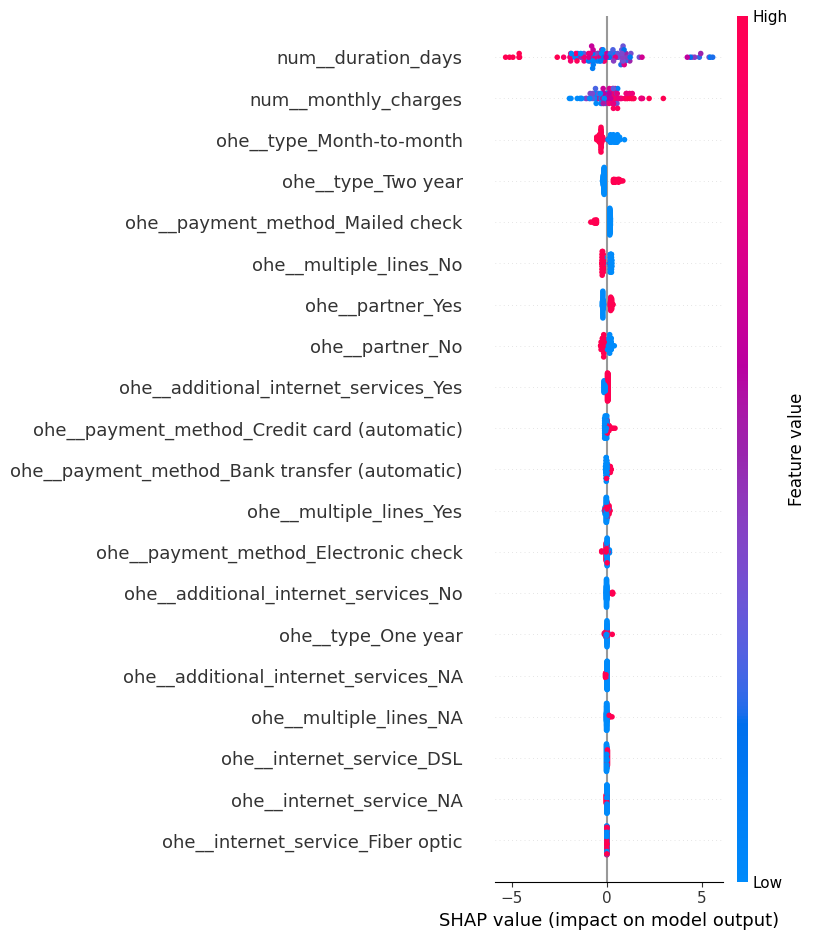

In [65]:
#извлекаем из пайплайна
best_model_pipeline = random_search.best_estimator_
preprocessor = best_model_pipeline.named_steps['preprocessor']
model = best_model_pipeline.named_steps['models']

#трансформируем выборку
X_train_sample = X_train.sample(100, random_state=RANDOM_STATE)
X_transformed = preprocessor.transform(X_train_sample)
feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

#создаем Explainer и смотрим SHAP-значения
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed_df)
shap.summary_plot(shap_values, X_transformed_df, feature_names=feature_names)

- **Продолжительность контракта** является наиболее важным признаком. Клиенты с большим сроком контракта (3 и более лет) склонны сохранять инерцию - очевидно, их всё устраивает. Ожидаемо некоторое число разрывов контракта со стороны новых клиентов: их в принципе много, какая-то доля разрывов неизбежна. Критична группа середнячков, что мы и видели еще на графике - абоненты на сроке от 1.5 до 3 лет.
- **Стоимость услуг** важный фактор для абонентов. Вероятность разрыва контракта имеет прямую зависимость от величины ежемесячной стоимости связи для клиента.
- **Контракт с помесячной оплатой** определенно является более стабильным типом. Вероятно, так и общая стоимость услуг меньше ощущается, и нет ощущения "закабаленности" с реактивным желанием сменить оператора.
- **Контракты с двухгодичной оплатой** являются группой риска. Причины могут быть разными: единовременный платеж делает стоимость более ощутимой, фрустрация из-за отстуствия гибкости и "прогресса" (т.е. на рынке появляются новые предложения, но абонент жестко ограничен своим оплаченным пакетом услуг), цикл для рынка, т.д.
- **Подкючение к дополнительным сервисам и обслуживание нескольких телефонных линий** делает клиента более критичным к контракту. Возможно, это вопрос общей стоимости услуг, а возможно - их качества или осознанности подключения (т.е. клиенту навязали покупку, но впоследствии он ощутил скорее потерю денег, чем реальную пользу продукта).
- **Наличие супругов** и разрыв контрактов также имеют примечательную связь. Подлинные причины такой связи могут быть различны: высокая стоимость в сочетании координировать свои расходы с партнерами, наличие/отсутствие бонусов при общении внутри сети, которыми супруги могут/не могут пользоваться в зависимости от их выбора операторов, т.д.
____

Резюмируя, можно сказать, что клиенты чувствительны к цене, гибкости и прогрессу условий. Кризисным моментом является срок около 2 лет. Если к этому моменту у клиента накопились какие-то претензии к связи, то высока вероятность разрыва контракта.

### Выводы по созданию модели

Лучше всех проявила себя модель CatBoostClassifier со следующими параметрами:
- max_depth=2
- learning_rate=0.25
- n_estimators=1000
- препроцессор числовых значений - MinMaxScaler
- обработка категориальных значений - OneHotEncoder
_____

Метрика модели на тесте - 0.95
____

Для более полного выявления рисков разрыва контракта рекомендуется порог модели для выявления риска увольнения - около 0.6. На этом значении мы получаем точность выявления разрывов около 98% без заметных потерь для обобщающей способности модели.
____

Самыми важными признаками для прогноза оттока клиентов являются следующие:

- Продолжительность контракта (срок более 3 лет >> риск разрыва минимален; средний срок от 1.5 до 3 лет >> риск разрыва при подтверждении другими факторами высок)
- Ежемесячная стоимость услуг (выше стоимость >> выше вероятность разрыва)
- Тип контракта (регулярная небольшая оплата (каждый месяц) >> низкая вероятность разрыва; большая сумма за большой период (два года) >> высокая вероятность разрыва)
- Степень вовлеченности в продукт (больше обслуживаемых линий и/или дополнительных сервисов >> выше риск прекращения контракта)
- Наличие супругов (есть партнер >> выше риск пересмотра статуса контракта)

## Общие выводы

**Ход проекта**

**Модель предсказания удовлетворенности сотрудников**
1. **Обзор и предобработка данных**
   - В целом в данных не выявлено значительных недостатков или системных проблем, корректировки минимальны.
   - Был выделен целевой признак 'breakup_status' на основании признака 'end_date', даты прекращения контракта: если дата есть - статус контракта 1, если ее нет - 0.
   - Исходные признаки начала и окончания контракта были удалены, чтобы модель в дальнейшем не привязывалась к определеному [всё время изменяющемуся] периоду времени. На основе исходных признаков даты начала и окончания контракта был создан более универсальный признак - общая продолжительность контракта в днях.
   - Для дальнейшей работы данные из 4 датасетов были объединены по id абонентов.
   - Для исследования определнно была бы полезна лучшая координация данных при выгрузке: данных не так много, чтобы из-за несовпадений клиентов в таблицах отрезать по 15% датасета, но и достоверное их восстановление аналитиком вне бизнеса затруднительно.
2. **Исследовательский анализ данных**
   - Наблюдается заметный дисбаланс целевого признака: из всех контрактов только 16% являются прекращенными. Нельзя уверенно сказать, является ли такое положение нормой для рынка, поэтому дисбаланс никак искусственно не корректировался - просто был учтен в дальнейшем при обучении, тесте и анализе модели.
   - Исследовательский анализ был проведен в контексте статуса контракта, чтобы выявить характерные особенности группы клиентов, расторгающих контракт.
   - На этапе исследовательского анализа были выявлены следующие особенности:
     - Почти всегда вероятность разрыва контракта выше в связи с большей погруженностью клиентов в продукт - и, вероятно, увеличением платежа в этой связи: среди тех, кто достоверно пользовался специфицическими интернет-услугами или имел несколько телефонных линий, доля расторжений стабильно выше обычного.
     - Другими категориальными признаками, связанными с бОльшей долей расторжений, являются наличие брачного партнера и получение счета почтой, но здесь связь в лучшем случае через какой-то сторонний признак, а в худшем случае - это просто совпадение.
     - Клиенты также демонстрируют заметную чувствительность к цене услуг: высокие ежемесячные и общие расходы более характерны для клиентов, решивших расторгнуть контракт (кроме небольшой группы оч лояльных премиум-потребителей).
     - На чувствительность к цене также указывает значительно меньшая доля расторжений среди клиентов с помесячной оплатой: единоразовый платеж за год-два с большей вероятностью будет ощущаться как большой или, как минимум, как повод задуматься.
     - Самый вероятный период расторжения контракта - на сроке от 1.5 до 3 лет использования услуг.
   - В данных не обнаружено аномалий или неадекватных, неправдоподобных значений. 
4. **Корреляционный анализ**
   - По результатам анализа корреляции и смысла признаков был выделен следующий финальный список наиболее перспективных признаков для разработки и выбора модели, а также анализа рисков оттока:
     - Тип контракта по регулярности платежа
     -  Метод оплаты
     -  Текущий размер ежемесячных затрат
     -  Продолжительность контракта
     -  Наличие у клиента супруга
     -  Подключение нескольких телефонных линий
     -  Тип интернет-подключения
     -  Подписка на дополнительные интернет-сервисы - *этот признак был создан в качестве более универсальной замены группе признаков из датасета internet с сильной мультиколинеарностью*
5. **Обучение и выбор моделей**
   - Лучше всех проявила себя модель CatBoostClassifier со следующими параметрами:
     - max_depth=2
     - learning_rate=0.25
     - n_estimators=1000
     - препроцессор числовых значений - MinMaxScaler
     - обработка категориальных значений - OneHotEncoder
   - Метрика лучшей модели на тесте - 0.95
   - Для более полного выявления рисков разрыва контракта рекомендуется порог модели для выявления риска увольнения - около 0.6. На этом значении мы получаем точность выявления разрывов около 98% без заметных потерь для обобщающей способности модели.
6. **Анализ важности признаков**
   - Самыми важными признаками для прогноза оттока клиентов являются следующие:
     - Продолжительность контракта (срок более 3 лет >> риск разрыва минимален; средний срок от 1.5 до 3 лет >> риск разрыва при подтверждении другими факторами высок)
     - Ежемесячная стоимость услуг (выше стоимость >> выше вероятность разрыва)
     - Тип контракта (регулярная небольшая оплата (каждый месяц) >> низкая вероятность разрыва; большая сумма за большой период (два года) >> высокая вероятность разрыва)
     - Степень вовлеченности в продукт (больше обслуживаемых линий и/или дополнительных сервисов >> выше риск прекращения контракта)
     - Наличие супругов (есть партнер >> выше риск пересмотра статуса контракта)
_____

**Дополнительные рекомендации**

**Своевременная актуализация пакета услуг для клиентов**

Удержание клиентов (в т.ч. за счет бонусов, снижения тарифов и т.д.) не обязательно выгоднее с точки зрения бизнеса, чем хорошая первичная продажа (в т.ч. продажа большего числа допсервисов, оформление долгосрочного контракта и т.д.). Однако, всегда полезна налаженная обратная связь и бОльшая гибкость тарифов и дополнительных предложений, чтобы клиент имел возможность вовремя актуализировать пакет своих услуг в рамках одного оператора - до "кризисного" срока контракта, который случается через приблизительно 2 года пользования услугами сети. 

Если транзит текущего клиента (пусть и в сторону более дешевого тарифа) в моменте равноценен привлечению нового клиента (на такой же недорогой тариф), то это может стать более выгодным решением в перспективе - после третьего года клиенты становятся ну очень инертными.

**"Парная терапия"**

Хотя наличие супругов является далеко не критерием первостепенной важности, развитие пакетных предложений - для супругов, семей, близких друзей, т.д. - может быть хорошим стабилизирующим фактором при соблюдении общей актуальности предложения рынку.